# Stock Market Prediction - Feature Engineering

This notebook explores and creates technical indicators and features for ML models. 

Dataset: 15 stocks, 11,500+ records (Sep 1 - Oct 15, 2025)

Goals:
1. Load and explore the data
2. Create technical indicators (MA, RSI, MACD, Bollinger Bands)
3. Engineer time-based features
4. Analyze feature correlations
5. Prepare final feature set for modeling

In [1]:
import sys
from pathlib import Path

# Add project root to path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import project modules
from src.data_loader import DataLoader
from src.config import config

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Display settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

print("Imports complete")
print(f"Config loaded: {config.data_mode} mode")
print(f"Historical days: {config.HISTORICAL_DAYS}")

Imports complete
Config loaded: LOCAL mode
Historical days: 365


## Load Data

In [2]:
loader = DataLoader(use_local=True)
df = loader.load_all_data()

DataLoader initialized in LOCAL mode.

Loading all available stock data...

Loading data from /home/pius/dev-projects/stock-market-prediction/data/raw/all_stocks_historical.parquet...
Loaded 11,500 records from local parquet file.
✅ Loaded 11,500 records for 15 stocks


In [3]:
print(f"Shape: {df.shape}")

Shape: (11500, 13)


In [4]:
print(f"Columns: {df.columns.tolist()}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

Columns: ['symbol', 'open_price', 'high', 'low', 'close_price', 'volume', 'market_cap', 'timestamp', 'date_only', 'timestamp_et', 'hour', 'day_of_week', 'is_trading_hours']
Date range: 2025-09-01 07:27:23.423846+00:00 to 2025-10-15 07:12:03.959273+00:00


In [5]:
print(f"Memory usage: {df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")

Memory usage: 1.91 MB


## Data Inspection

In [6]:
df.head()

symbol  open_price   high    low  close_price   volume    market_cap  \
0  2222.SR       23.81  23.82  23.73        23.75   517621  5.744056e+12   
1  2222.SR       23.70  23.71  23.69        23.69    35782  5.729545e+12   
2  2222.SR       23.63  23.63  23.63        23.63        0  5.715033e+12   
3  2222.SR       23.63  23.64  23.60        23.61  2372396  5.710197e+12   
4  2222.SR       23.61  23.61  23.57        23.59  1521688  5.705360e+12   

                         timestamp   date_only  \
0 2025-09-01 07:27:29.329835+00:00  2025-09-01   
1 2025-09-01 08:17:47.795969+00:00  2025-09-01   
2 2025-09-01 09:15:07.264998+00:00  2025-09-01   
3 2025-09-01 10:14:05.476706+00:00  2025-09-01   
4 2025-09-01 11:10:40.868525+00:00  2025-09-01   

                      timestamp_et  hour  day_of_week  is_trading_hours  
0 2025-09-01 03:27:29.329835-04:00     3            0             False  
1 2025-09-01 04:17:47.795969-04:00     4            0             False  
2 2025-09-01 05:15:07.264998-04:00     5            0             False  
3 2025-09-01 06:14:05.476706-04:00     6            0             False  
4 2025-09-01 07:10:40.868525-04:00     7            0             False

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype                           
---  ------            --------------  -----                           
 0   symbol            11500 non-null  object                          
 1   open_price        11500 non-null  float64                         
 2   high              11500 non-null  float64                         
 3   low               11500 non-null  float64                         
 4   close_price       11500 non-null  float64                         
 5   volume            11500 non-null  int64                           
 6   market_cap        11499 non-null  float64                         
 7   timestamp         11500 non-null  datetime64[ns, UTC]             
 8   date_only         11500 non-null  object                          
 9   timestamp_et      11500 non-null  datetime64[ns, America/New_York]
 10  hour              1150

## EDA

### Records per Symbol

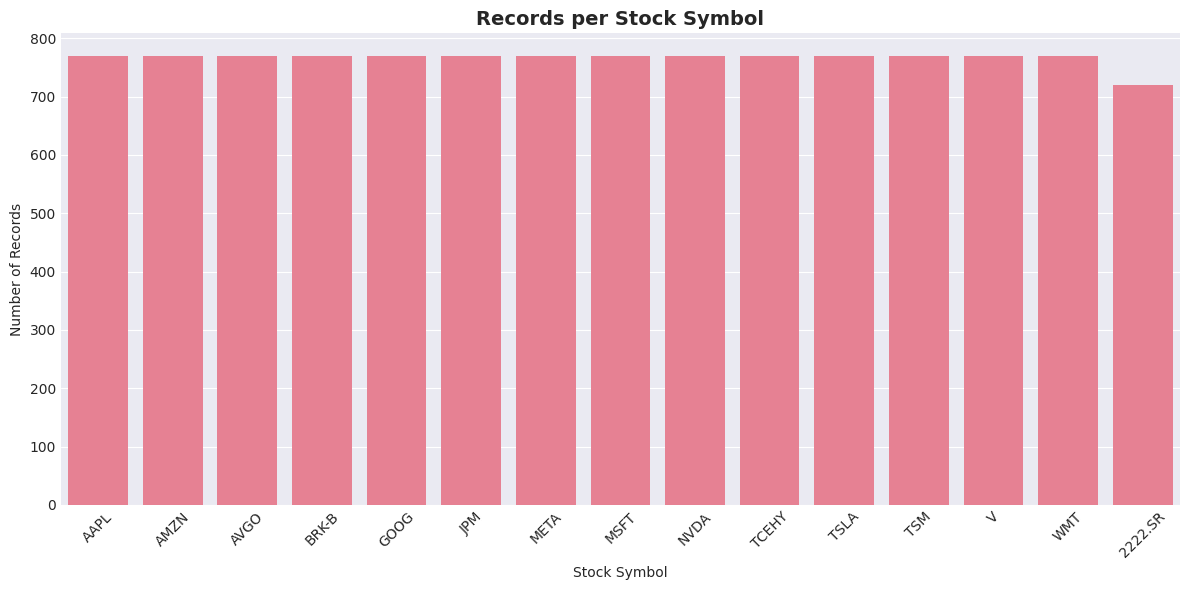

In [8]:
records_per_symbol = df.groupby("symbol").size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=records_per_symbol.index, y=records_per_symbol.values)
plt.title("Records per Stock Symbol", fontsize=14, fontweight="bold")
plt.xlabel("Stock Symbol")
plt.ylabel("Number of Records")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
print("Records per Symbol:")
print(records_per_symbol)

Records per Symbol:
symbol
AAPL       770
AMZN       770
AVGO       770
BRK-B      770
GOOG       770
JPM        770
META       770
MSFT       770
NVDA       770
TCEHY      770
TSLA       770
TSM        770
V          770
WMT        770
2222.SR    720
dtype: int64


### Price Trend Analysis

This is meant to understand the price trends of each stock over time.

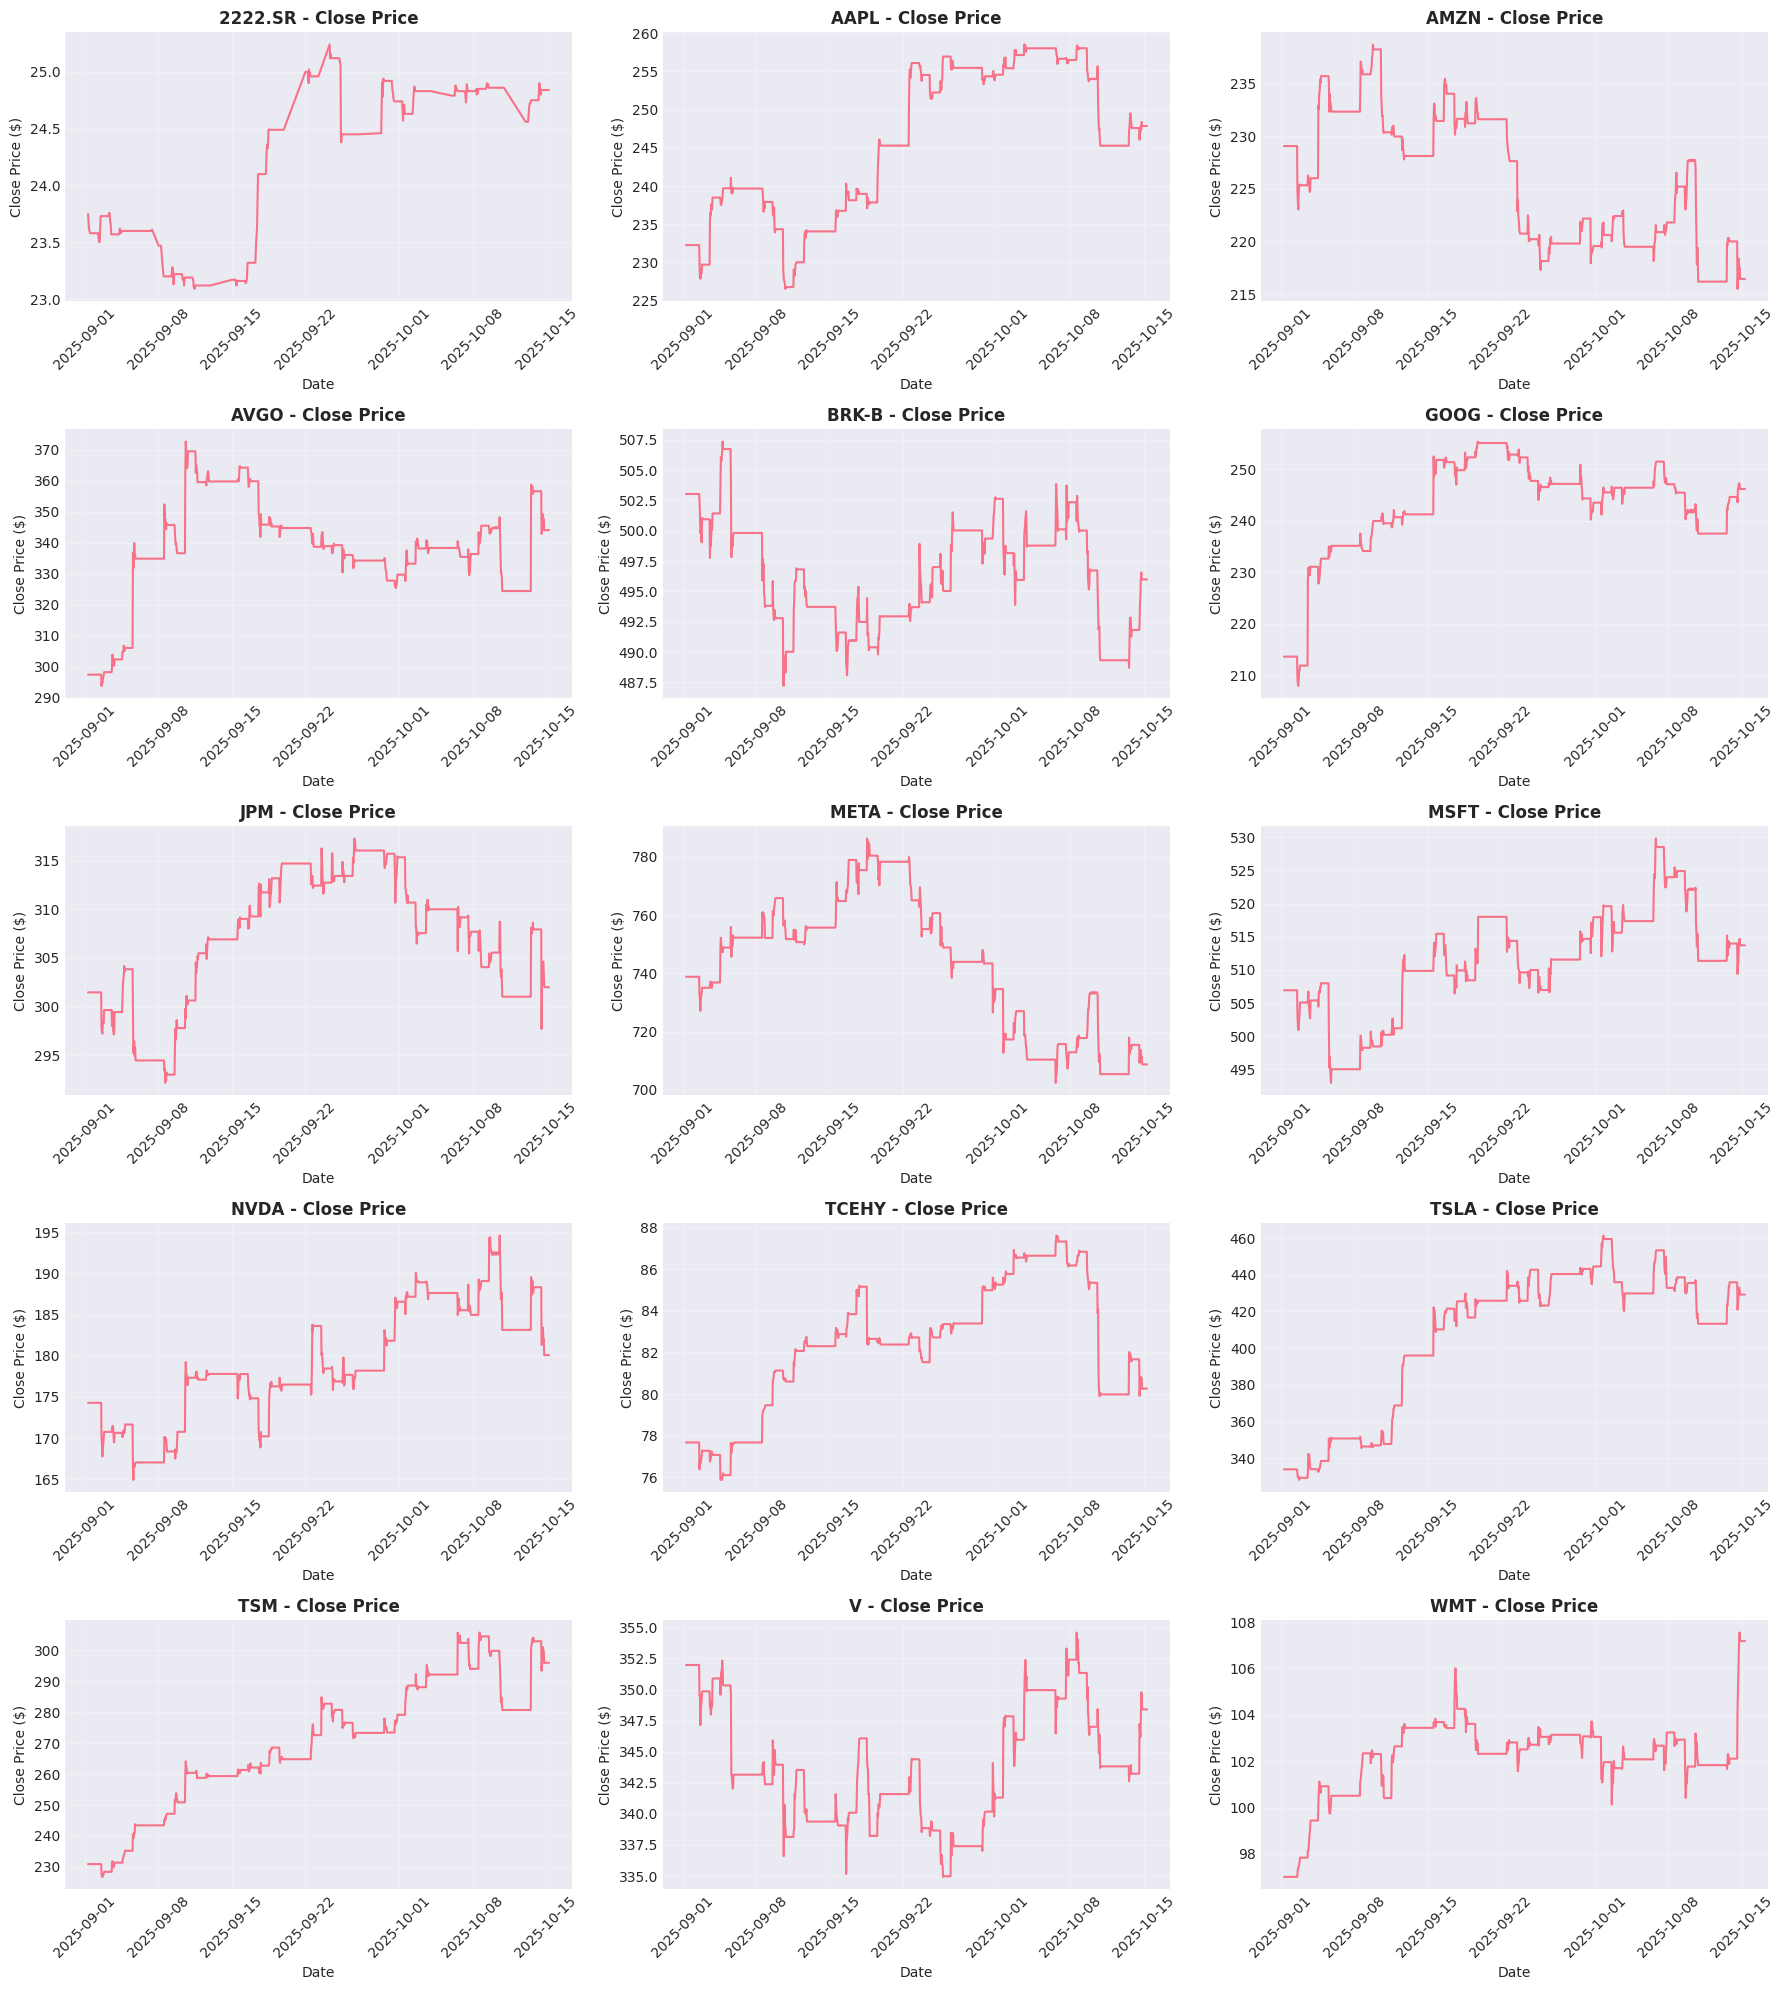

In [10]:
fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

symbols = df["symbol"].unique()

for i, symbol in enumerate(symbols):
    symbol_df = df[df["symbol"] == symbol].sort_values(by="timestamp")
    axes[i].plot(symbol_df["timestamp"], symbol_df["close_price"], linewidth=1.5)
    axes[i].set_title(f"{symbol} - Close Price", fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Close Price ($)")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Moving Averages

Here, we calculate short-term and long-term moving averages to identify trends. A moving average (MA) is a widely used indicator in technical analysis that helps smooth out price action by filtering out the "noise" from random price fluctuations. 

In [11]:
def add_moving_averages(df):
    """
    Add moving averages to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'close_price'.

    Returns:
    pd.DataFrame: DataFrame with moving averages added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of moving averages
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol

        # Simple Moving Averages
        df.loc[mask, "sma_5"] = df.loc[mask, "close_price"].rolling(window=5).mean()
        df.loc[mask, "sma_10"] = df.loc[mask, "close_price"].rolling(window=10).mean()
        df.loc[mask, "sma_20"] = df.loc[mask, "close_price"].rolling(window=20).mean()
        df.loc[mask, "sma_50"] = df.loc[mask, "close_price"].rolling(window=50).mean()

        # Exponential Moving Averages
        df.loc[mask, "ema_5"] = (
            df.loc[mask, "close_price"].ewm(span=5, adjust=False).mean()
        )
        df.loc[mask, "ema_10"] = (
            df.loc[mask, "close_price"].ewm(span=10, adjust=False).mean()
        )
        df.loc[mask, "ema_20"] = (
            df.loc[mask, "close_price"].ewm(span=20, adjust=False).mean()
        )
        df.loc[mask, "ema_50"] = (
            df.loc[mask, "close_price"].ewm(span=50, adjust=False).mean()
        )

    return df


df = add_moving_averages(df)
print("Moving averages added to DataFrame.")
df.head()

Moving averages added to DataFrame.


symbol  open_price   high    low  close_price   volume    market_cap  \
0  2222.SR       23.81  23.82  23.73        23.75   517621  5.744056e+12   
1  2222.SR       23.70  23.71  23.69        23.69    35782  5.729545e+12   
2  2222.SR       23.63  23.63  23.63        23.63        0  5.715033e+12   
3  2222.SR       23.63  23.64  23.60        23.61  2372396  5.710197e+12   
4  2222.SR       23.61  23.61  23.57        23.59  1521688  5.705360e+12   

                         timestamp   date_only  \
0 2025-09-01 07:27:29.329835+00:00  2025-09-01   
1 2025-09-01 08:17:47.795969+00:00  2025-09-01   
2 2025-09-01 09:15:07.264998+00:00  2025-09-01   
3 2025-09-01 10:14:05.476706+00:00  2025-09-01   
4 2025-09-01 11:10:40.868525+00:00  2025-09-01   

                      timestamp_et  hour  day_of_week  is_trading_hours  \
0 2025-09-01 03:27:29.329835-04:00     3            0             False   
1 2025-09-01 04:17:47.795969-04:00     4            0             False   
2 2025-09-01 05:15:07.264998-04:00     5            0             False   
3 2025-09-01 06:14:05.476706-04:00     6            0             False   
4 2025-09-01 07:10:40.868525-04:00     7            0             False   

    sma_5  sma_10  sma_20  sma_50      ema_5     ema_10     ema_20     ema_50  
0     NaN     NaN     NaN     NaN  23.750000  23.750000  23.750000  23.750000  
1     NaN     NaN     NaN     NaN  23.730000  23.739091  23.744286  23.747647  
2     NaN     NaN     NaN     NaN  23.696667  23.719256  23.733401  23.743033  
3     NaN     NaN     NaN     NaN  23.667778  23.699391  23.721649  23.737816  
4  23.654     NaN     NaN     NaN  23.641852  23.679502  23.709111  23.732020

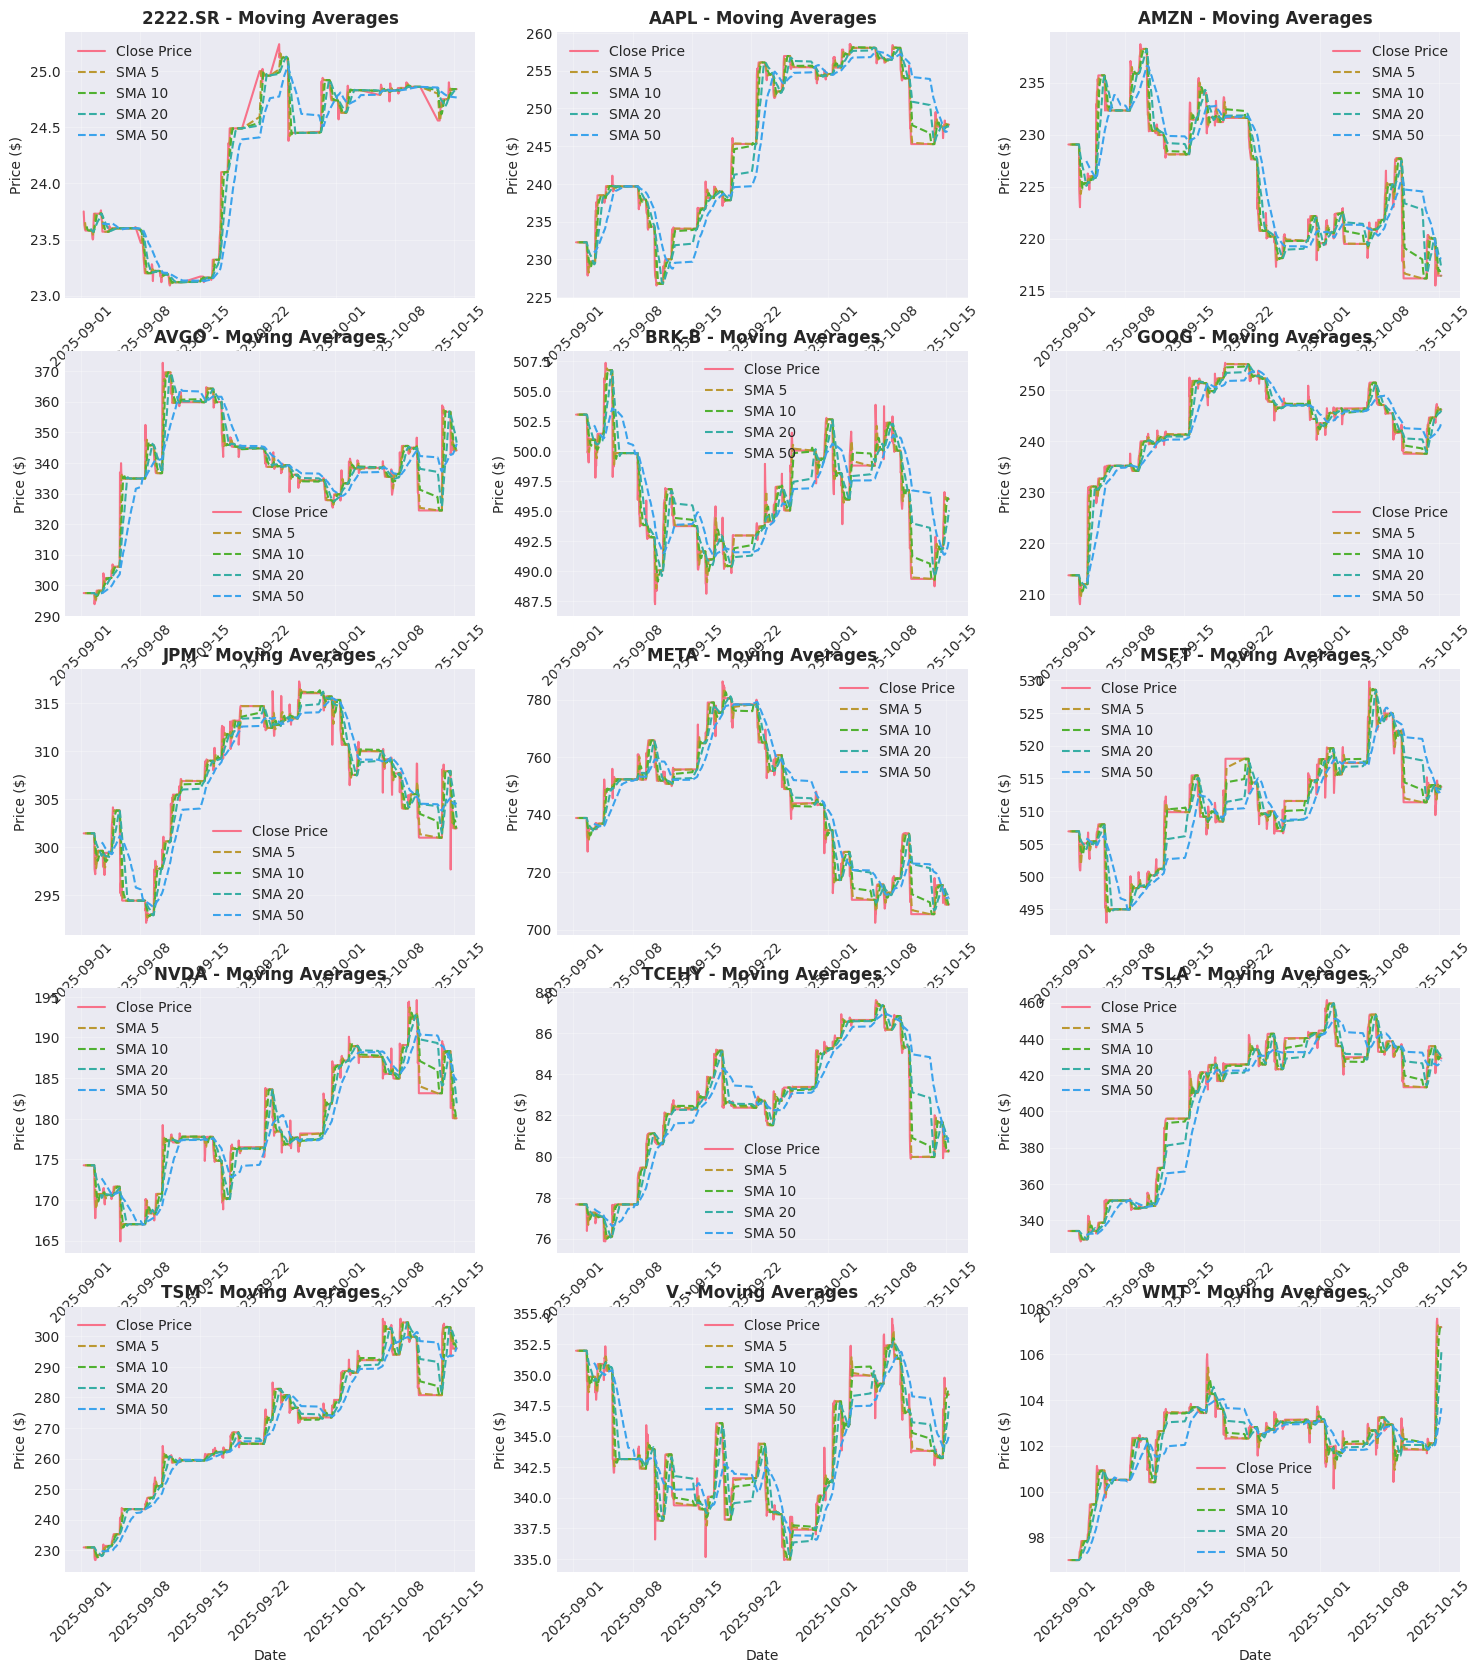

In [12]:
# Visualize moving averages

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

symbols = df["symbol"].unique()

for i, symbol in enumerate(symbols):
    symbol_df = df[df["symbol"] == symbol].sort_values(by="timestamp")

    axes[i].plot(
        symbol_df["timestamp"],
        symbol_df["close_price"],
        label="Close Price",
        linewidth=1.5,
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["sma_5"], label="SMA 5", linestyle="--"
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["sma_10"], label="SMA 10", linestyle="--"
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["sma_20"], label="SMA 20", linestyle="--"
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["sma_50"], label="SMA 50", linestyle="--"
    )

    axes[i].set_title(f"{symbol} - Moving Averages", fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Price ($)")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

### Adding Relative Strength Index (RSI)

RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100 and is typically used to identify overbought or oversold conditions in a market.

In [13]:
def add_rsi(df, period=14):
    """
    Add Relative Strength Index (RSI) to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'close_price'.
    period (int): Period for RSI calculation.

    Returns:
    pd.DataFrame: DataFrame with RSI added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of RSI
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol
        close_prices = df.loc[mask, "close_price"]

        # Calculate price changes
        delta = close_prices.diff()

        # Separate gains and losses
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period).mean()

        # Calculate RS and RSI
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))

        df.loc[mask, "rsi"] = rsi

    return df


df = add_rsi(df)
print(f' RSI range: {df["rsi"].min()} to {df["rsi"].max()}')

 RSI range: 0.0 to 100.0


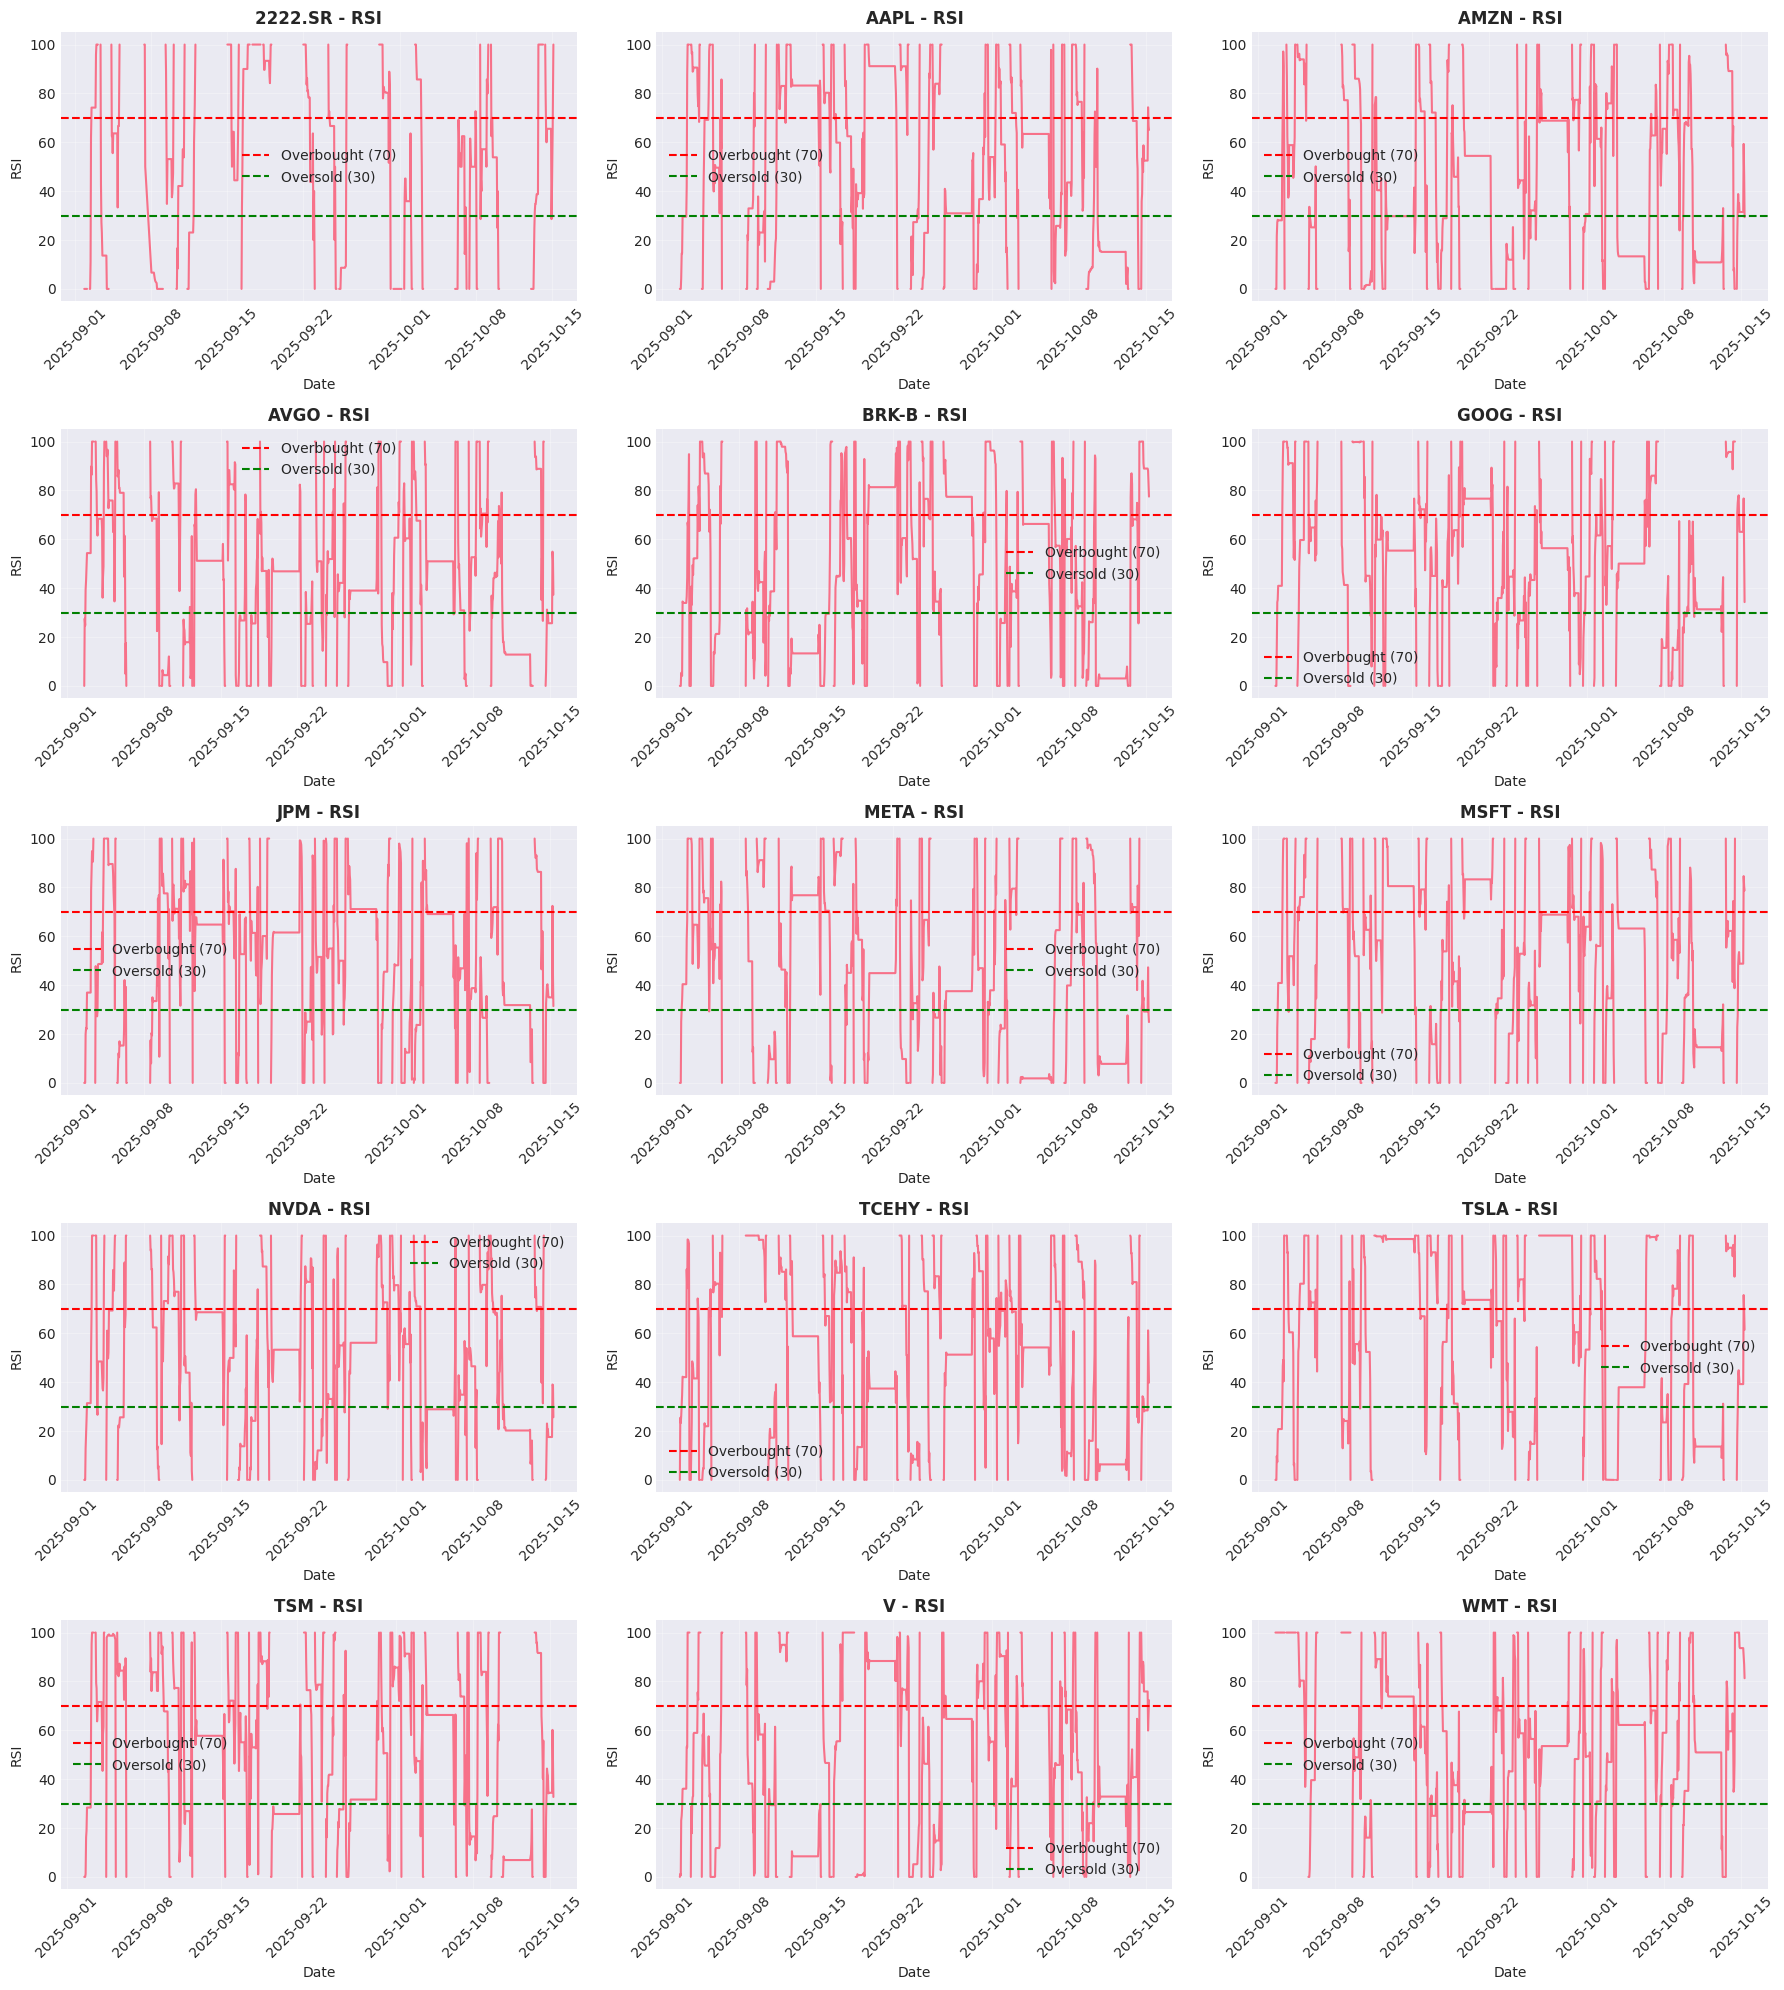

In [14]:
# Visualizing RSI

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

symbols = df["symbol"].unique()

for i, symbol in enumerate(symbols):
    symbol_df = df[df["symbol"] == symbol].sort_values(by="timestamp")

    axes[i].plot(symbol_df["timestamp"], symbol_df["rsi"], linewidth=1.5)
    axes[i].axhline(70, color="red", linestyle="--", label="Overbought (70)")
    axes[i].axhline(30, color="green", linestyle="--", label="Oversold (30)")

    axes[i].set_title(f"{symbol} - RSI", fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("RSI")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### MACD (Moving Average Convergence Divergence)

MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA. The result of that calculation is the MACD line. A nine-day EMA of the MACD called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals.

In [15]:
def add_macd(df, fast=12, slow=26, signal=9):
    """
    Add MACD (Moving Average Convergence Divergence) to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'close_price'.
    fast (int): Fast EMA period.
    slow (int): Slow EMA period.
    signal (int): Signal line period.

    Returns:
    pd.DataFrame: DataFrame with MACD and Signal Line added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of MACD
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol
        close_prices = df.loc[mask, "close_price"]

        # Calculate MACD
        exp1 = close_prices.ewm(span=fast, adjust=False).mean()
        exp2 = close_prices.ewm(span=slow, adjust=False).mean()

        macd = exp1 - exp2
        macd_signal = macd.ewm(span=signal, adjust=False).mean()
        macd_hist = macd - macd_signal

        df.loc[mask, "macd"] = macd
        df.loc[mask, "macd_signal"] = macd_signal
        df.loc[mask, "macd_hist"] = macd_hist

    return df


df = add_macd(df)
print(f' MACD columns: {[col for col in df.columns if "macd" in col]}')

 MACD columns: ['macd', 'macd_signal', 'macd_hist']


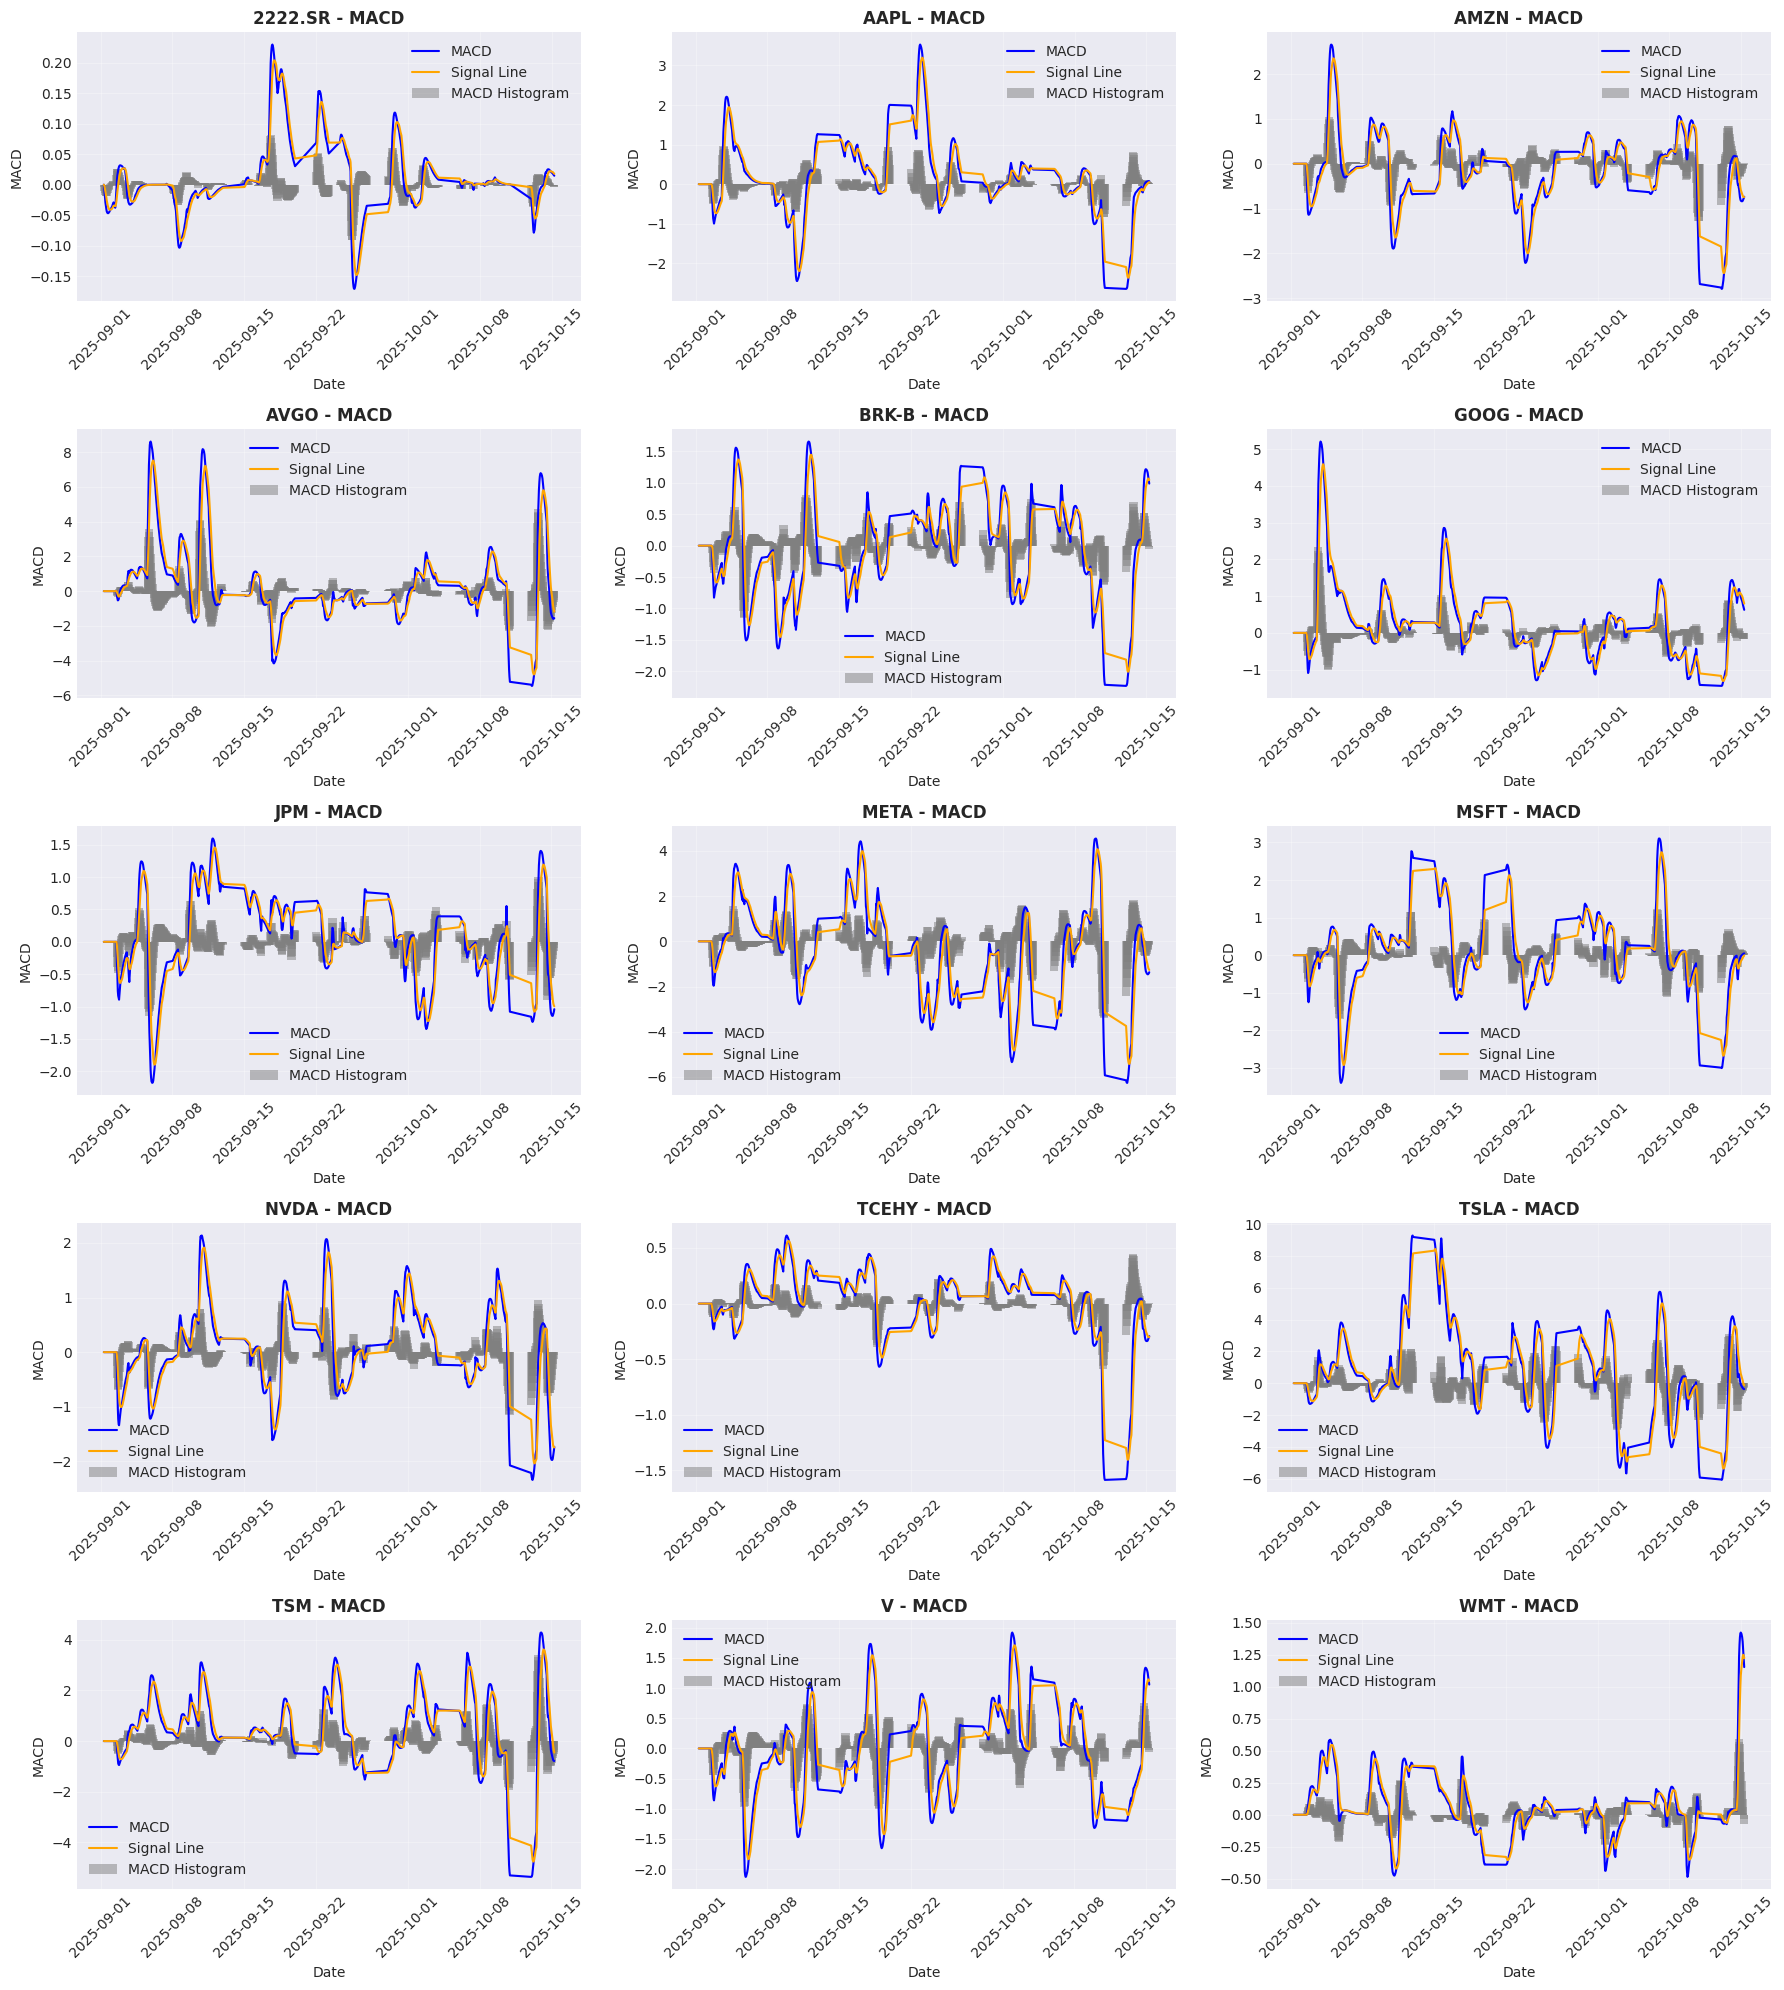

In [16]:
# Visualizing MACD

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

symbols = df["symbol"].unique()

for i, symbol in enumerate(symbols):
    symbol_df = df[df["symbol"] == symbol].sort_values(by="timestamp")

    axes[i].plot(symbol_df["timestamp"], symbol_df["macd"], label="MACD", color="blue")
    axes[i].plot(
        symbol_df["timestamp"],
        symbol_df["macd_signal"],
        label="Signal Line",
        color="orange",
    )
    axes[i].bar(
        symbol_df["timestamp"],
        symbol_df["macd_hist"],
        label="MACD Histogram",
        color="gray",
        alpha=0.5,
    )

    axes[i].set_title(f"{symbol} - MACD", fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("MACD")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Bollinger Bands

Bollinger Bands are a volatility indicator that consists of a middle band (SMA) and two outer bands (standard deviations). They help identify overbought or oversold conditions in the market.

In [17]:
def add_bollinger_bands(df, period=20, std_dev=2):
    """
    Add Bollinger Bands to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'close_price'.
    period (int): Period for the moving average.
    std_dev (int): Number of standard deviations for the bands.

    Returns:
    pd.DataFrame: DataFrame with Bollinger Bands added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of Bollinger Bands
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol
        close_prices = df.loc[mask, "close_price"]

        # Calculate components
        bb_middle = close_prices.rolling(window=period).mean()
        bb_std = close_prices.rolling(window=period).std()

        bb_upper = bb_middle + (bb_std * std_dev)
        bb_lower = bb_middle - (bb_std * std_dev)
        bb_width = bb_upper - bb_lower
        bb_percent_b = (close_prices - bb_lower) / (bb_upper - bb_lower)

        df.loc[mask, "bb_middle"] = bb_middle
        df.loc[mask, "bb_upper"] = bb_upper
        df.loc[mask, "bb_lower"] = bb_lower
        df.loc[mask, "bb_width"] = bb_width
        df.loc[mask, "bb_percent_b"] = bb_percent_b

    return df


df = add_bollinger_bands(df)
print(f' Bollinger Bands columns: {[col for col in df.columns if "bb_"in col]}')

 Bollinger Bands columns: ['bb_middle', 'bb_upper', 'bb_lower', 'bb_width', 'bb_percent_b']


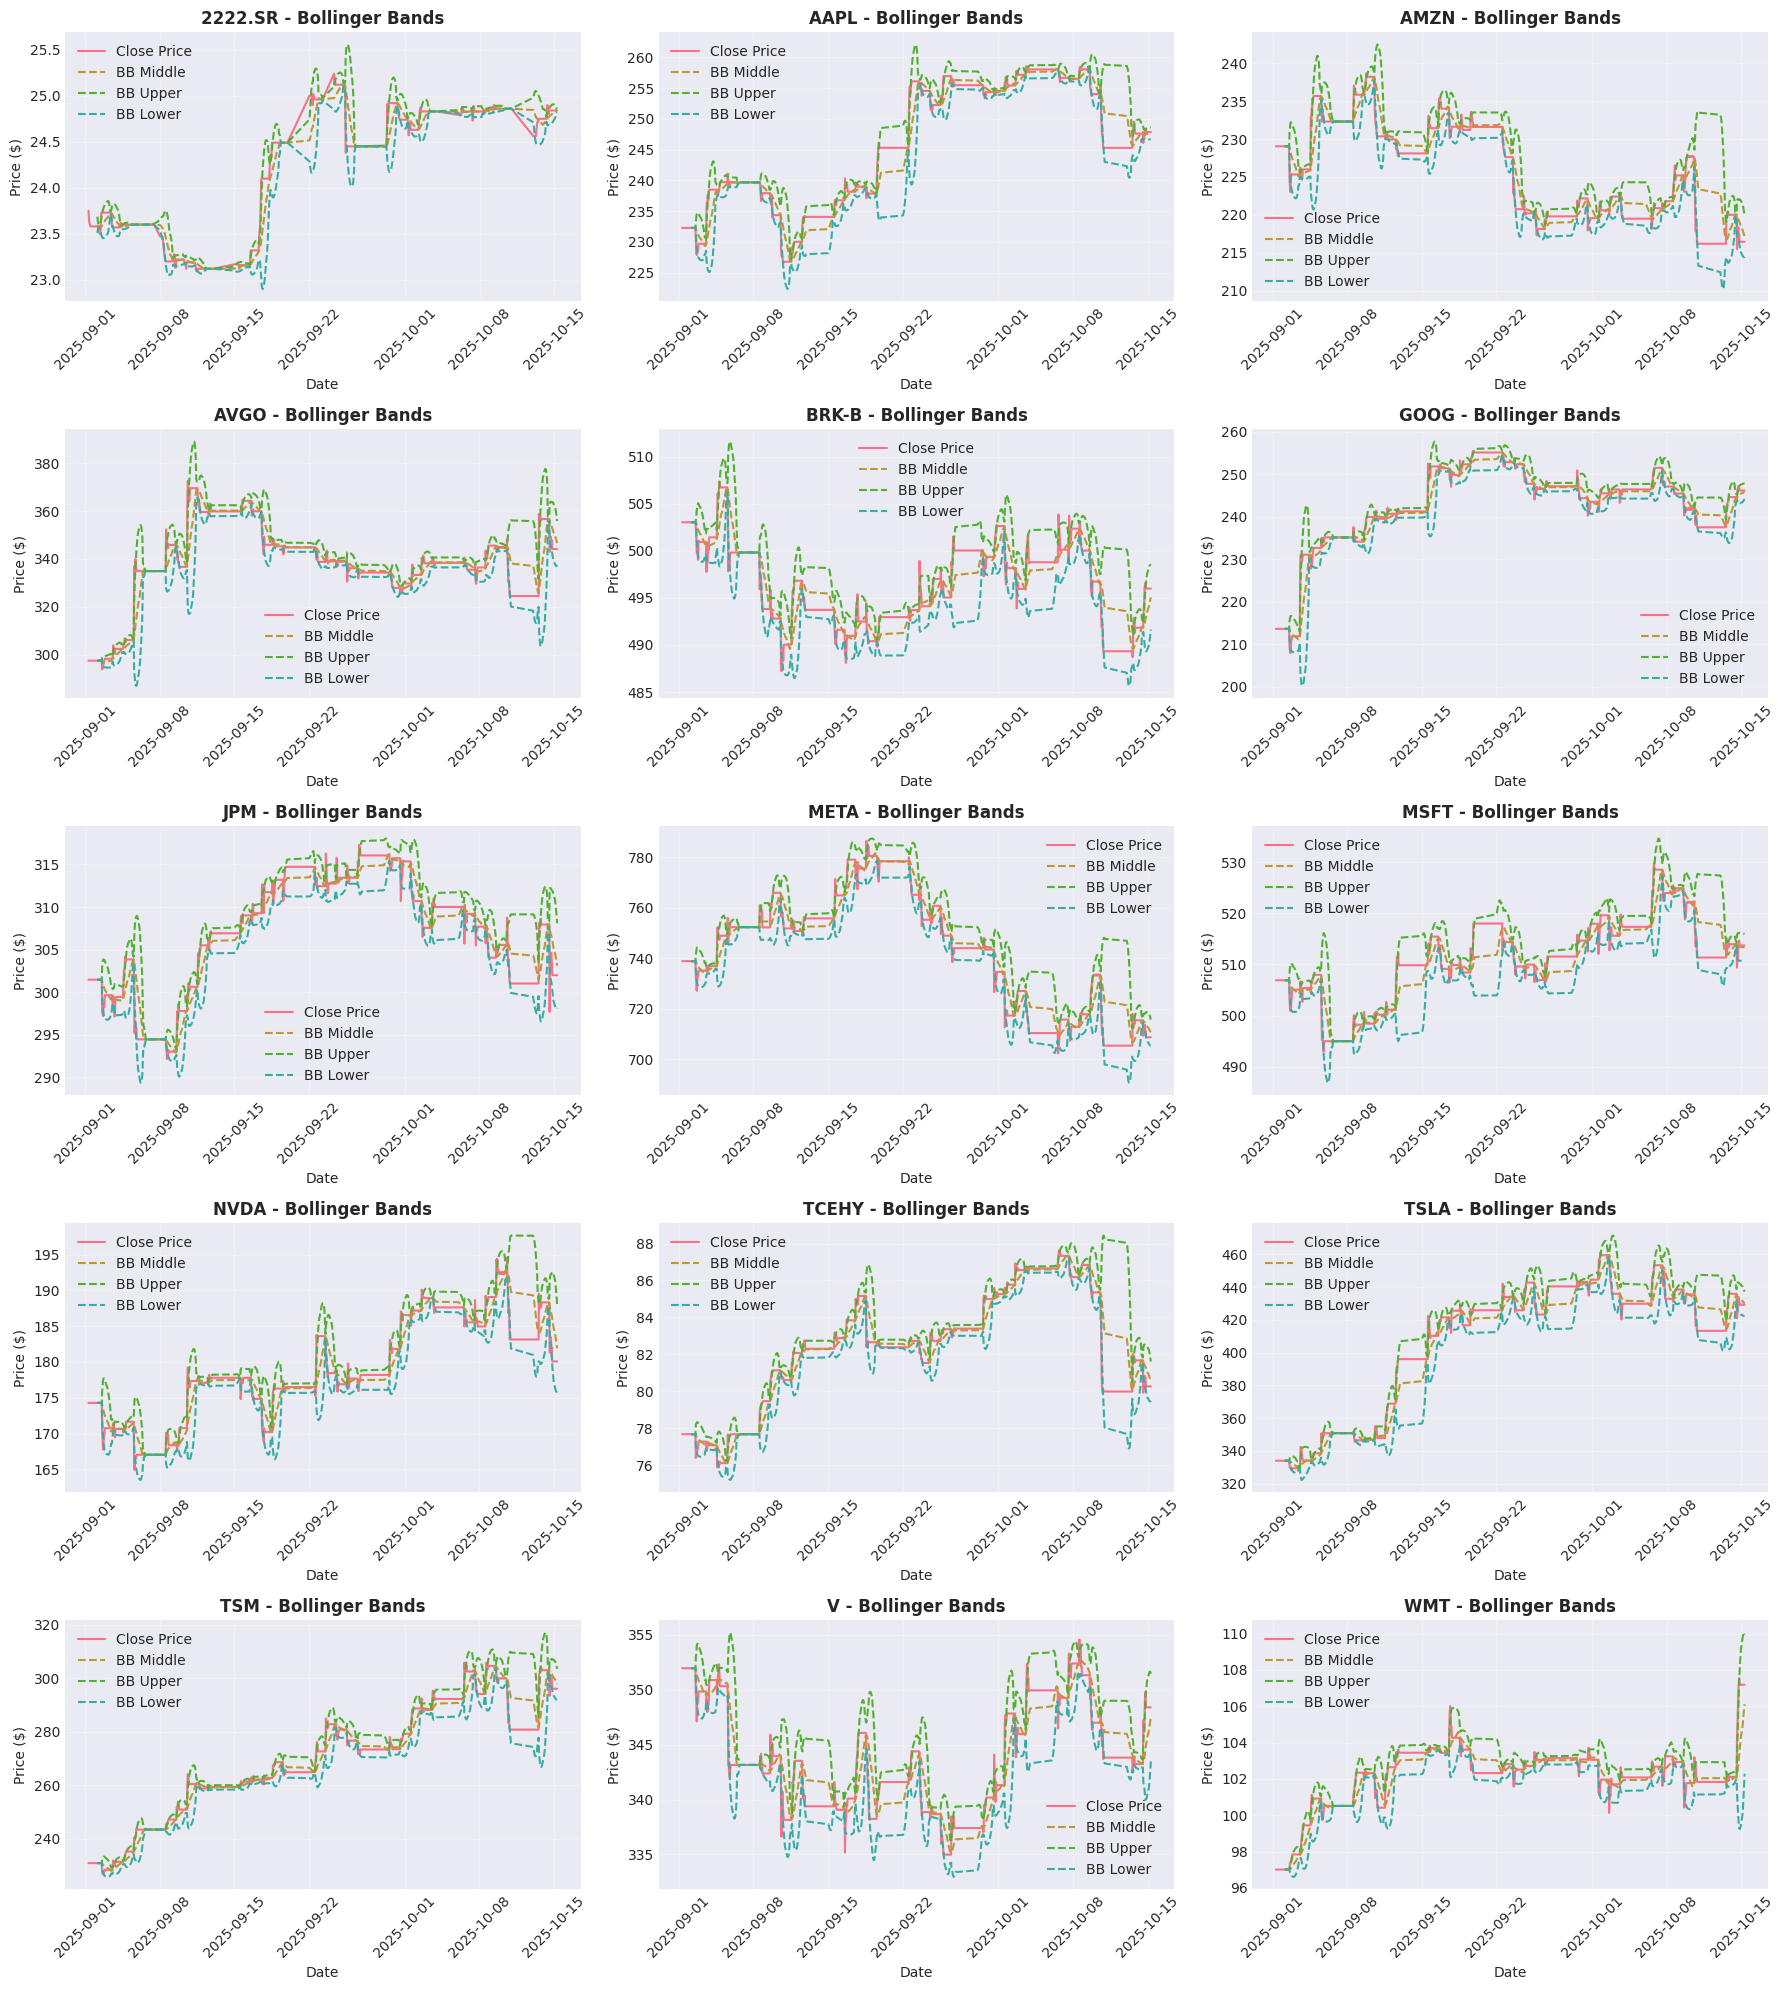

In [18]:
# Visualizing Bollinger Bands

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
axes = axes.flatten()

symbols = df["symbol"].unique()

for i, symbol in enumerate(symbols):
    symbol_df = df[df["symbol"] == symbol].sort_values(by="timestamp")

    axes[i].plot(
        symbol_df["timestamp"],
        symbol_df["close_price"],
        label="Close Price",
        linewidth=1.5,
    )
    axes[i].plot(
        symbol_df["timestamp"],
        symbol_df["bb_middle"],
        label="BB Middle",
        linestyle="--",
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["bb_upper"], label="BB Upper", linestyle="--"
    )
    axes[i].plot(
        symbol_df["timestamp"], symbol_df["bb_lower"], label="BB Lower", linestyle="--"
    )

    axes[i].set_title(f"{symbol} - Bollinger Bands", fontweight="bold")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Price ($)")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Price features

These features include daily returns, price changes, and volatility measures. These features help capture the stock's price dynamics and can be useful for predicting future price movements.

In [20]:
def add_price_features(df):
    """
    Add price-related features to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'close_price'.

    Returns:
    pd.DataFrame: DataFrame with price features added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of price features
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol

        # Price changes
        df.loc[mask, "price_change"] = df.loc[mask, "close_price"].diff()
        df.loc[mask, "price_change_pct"] = (
            df.loc[mask, "close_price"].pct_change() * 100
        )

        # Intraday ranges
        df.loc[mask, "high_low_range"] = df.loc[mask, "high"] - df.loc[mask, "low"]
        df.loc[mask, "open_close_range"] = (
            df.loc[mask, "close_price"] - df.loc[mask, "open_price"]
        )
        df.loc[mask, "high_low_pct"] = (
            df.loc[mask, "high_low_range"] / df.loc[mask, "low"]
        ) * 100

        # Returns
        df.loc[mask, "returns"] = df.loc[mask, "close_price"].pct_change()
        df.loc[mask, "log_returns"] = np.log(
            df.loc[mask, "close_price"] / df.loc[mask, "close_price"].shift(1)
        )

        # Volatility
        df.loc[mask, "volatility_10d"] = (
            df.loc[mask, "returns"].rolling(window=10).std()
        )
        df.loc[mask, "volatility_20d"] = (
            df.loc[mask, "returns"].rolling(window=20).std()
        )

    return df


df = add_price_features(df)
print(
    f' Price feature columns: {[col for col in df.columns if col not in ["timestamp", "symbol", "open", "high", "low", "close_price", "volume"]]}'
)

 Price feature columns: ['open_price', 'market_cap', 'date_only', 'timestamp_et', 'hour', 'day_of_week', 'is_trading_hours', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'ema_5', 'ema_10', 'ema_20', 'ema_50', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_middle', 'bb_upper', 'bb_lower', 'bb_width', 'bb_percent_b', 'price_change', 'price_change_pct', 'high_low_range', 'open_close_range', 'high_low_pct', 'returns', 'log_returns', 'volatility_10d', 'volatility_20d']


### Volume features

These features include average volume, volume changes, and volume spikes. Volume is a key indicator of market activity and can provide insights into the strength of price movements.

In [21]:
def add_volume_features(df):
    """
    Add volume-related features to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'volume'.

    Returns:
    pd.DataFrame: DataFrame with volume features added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of volume features
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol

        # Volume changes
        df.loc[mask, "volume_change"] = df.loc[mask, "volume"].diff()
        df.loc[mask, "volume_change_pct"] = df.loc[mask, "volume"].pct_change() * 100

        # Volume moving averages
        df.loc[mask, "volume_ma_5"] = df.loc[mask, "volume"].rolling(window=5).mean()
        df.loc[mask, "volume_ma_10"] = df.loc[mask, "volume"].rolling(window=10).mean()
        df.loc[mask, "volume_ma_20"] = df.loc[mask, "volume"].rolling(window=20).mean()

        # Volume ratio
        df.loc[mask, "volume_ratio"] = (
            df.loc[mask, "volume"] / df.loc[mask, "volume_ma_20"]
        )

        # Price-Volume interaction
        df.loc[mask, "price_volume_corr"] = (
            df.loc[mask, "close_price"].rolling(window=20).corr(df.loc[mask, "volume"])
        )

    return df


df = add_volume_features(df)
print(
    f' Volume feature columns: {[col for col in df.columns if "volume" in col and col not in ["volume"]]}'
)

 Volume feature columns: ['volume_change', 'volume_change_pct', 'volume_ma_5', 'volume_ma_10', 'volume_ma_20', 'volume_ratio', 'price_volume_corr']


### Lag Features

Lag features are created by shifting the original time series data by a certain number of periods. This allows the model to learn from past values and can help capture temporal dependencies in the data. For example, a lag of 1 would use the previous day's closing price as a feature for predicting the current day's price.

In [41]:
def add_lag_features(df, lags=[1, 2, 3, 5, 10]):
    """
    Add lag features to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp' and 'close_price'.
    lags (list): List of lag periods to create.

    Returns:
    pd.DataFrame: DataFrame with lag features added.
    """

    df = df.copy()

    # Group by symbol for proper calculation of lag features
    for symbol in df["symbol"].unique():
        mask = df["symbol"] == symbol

        for lag in lags:

            # Price lags
            df.loc[mask, f"close_lag_{lag}"] = df.loc[mask, "close_price"].shift(lag)

            # Volume lags
            df.loc[mask, f"volume_lag_{lag}"] = df.loc[mask, "volume"].shift(lag)

            # Returns lags
            df.loc[mask, f"returns_lag_{lag}"] = df.loc[mask, "returns"].shift(lag)

    return df


df = add_lag_features(df)
print(f' Lag feature columns: {[col for col in df.columns if "lag" in col]}')

 Lag feature columns: ['close_lag_1', 'volume_lag_1', 'returns_lag_1', 'close_lag_2', 'volume_lag_2', 'returns_lag_2', 'close_lag_3', 'volume_lag_3', 'returns_lag_3', 'close_lag_5', 'volume_lag_5', 'returns_lag_5', 'close_lag_10', 'volume_lag_10', 'returns_lag_10']


### Time features

These features include day of the week, month, quarter, and whether the day is a holiday or weekend. Time features can help capture seasonal patterns and trends in stock prices.

In [23]:
def add_time_features(df):
    """
    Add time-related features to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing stock data with 'timestamp'.

    Returns:
    pd.DataFrame: DataFrame with time features added.
    """

    df = df.copy()

    df["day_of_month"] = df["timestamp"].dt.day
    df["month"] = df["timestamp"].dt.month
    df["quarter"] = df["timestamp"].dt.quarter

    # Cyclical encoding
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["day_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    df["day_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # Market session indicators
    df["is_market_open"] = df["timestamp"].dt.hour.between(9, 16).astype(int)
    df["is_pre_market"] = df["timestamp"].dt.hour.between(4, 9).astype(int)
    df["is_after_hours"] = df["timestamp"].dt.hour.between(16, 20).astype(int)

    return df


df = add_time_features(df)
print(
    f' Time feature columns: {[col for col in df.columns if col not in ["timestamp", "symbol", "open", "high", "low", "close_price", "volume"]]}'
)
df.head()

 Time feature columns: ['open_price', 'market_cap', 'date_only', 'timestamp_et', 'hour', 'day_of_week', 'is_trading_hours', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'ema_5', 'ema_10', 'ema_20', 'ema_50', 'rsi', 'macd', 'macd_signal', 'macd_hist', 'bb_middle', 'bb_upper', 'bb_lower', 'bb_width', 'bb_percent_b', 'price_change', 'price_change_pct', 'high_low_range', 'open_close_range', 'high_low_pct', 'returns', 'log_returns', 'volatility_10d', 'volatility_20d', 'volume_change', 'volume_change_pct', 'volume_ma_5', 'volume_ma_10', 'volume_ma_20', 'volume_ratio', 'price_volume_corr', 'close_lag_1', 'volume_lag_1', 'returns_lag_1', 'close_lag_2', 'volume_lag_2', 'returns_lag_2', 'close_lag_3', 'volume_lag_3', 'returns_lag_3', 'close_lag_5', 'volume_lag_5', 'returns_lag_5', 'close_lag_10', 'volume_lag_10', 'returns_lag_10', 'day_of_month', 'month', 'quarter', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_market_open', 'is_pre_market', 'is_after_hours']


symbol  open_price   high    low  close_price   volume    market_cap  \
0  2222.SR       23.81  23.82  23.73        23.75   517621  5.744056e+12   
1  2222.SR       23.70  23.71  23.69        23.69    35782  5.729545e+12   
2  2222.SR       23.63  23.63  23.63        23.63        0  5.715033e+12   
3  2222.SR       23.63  23.64  23.60        23.61  2372396  5.710197e+12   
4  2222.SR       23.61  23.61  23.57        23.59  1521688  5.705360e+12   

                         timestamp   date_only  \
0 2025-09-01 07:27:29.329835+00:00  2025-09-01   
1 2025-09-01 08:17:47.795969+00:00  2025-09-01   
2 2025-09-01 09:15:07.264998+00:00  2025-09-01   
3 2025-09-01 10:14:05.476706+00:00  2025-09-01   
4 2025-09-01 11:10:40.868525+00:00  2025-09-01   

                      timestamp_et  hour  day_of_week  is_trading_hours  \
0 2025-09-01 03:27:29.329835-04:00     3            0             False   
1 2025-09-01 04:17:47.795969-04:00     4            0             False   
2 2025-09-01 05:15:07.264998-04:00     5            0             False   
3 2025-09-01 06:14:05.476706-04:00     6            0             False   
4 2025-09-01 07:10:40.868525-04:00     7            0             False   

    sma_5  sma_10  sma_20  sma_50      ema_5     ema_10     ema_20     ema_50  \
0     NaN     NaN     NaN     NaN  23.750000  23.750000  23.750000  23.750000   
1     NaN     NaN     NaN     NaN  23.730000  23.739091  23.744286  23.747647   
2     NaN     NaN     NaN     NaN  23.696667  23.719256  23.733401  23.743033   
3     NaN     NaN     NaN     NaN  23.667778  23.699391  23.721649  23.737816   
4  23.654     NaN     NaN     NaN  23.641852  23.679502  23.709111  23.732020   

   rsi      macd  macd_signal  macd_hist  bb_middle  bb_upper  bb_lower  \
0  NaN  0.000000     0.000000   0.000000        NaN       NaN       NaN   
1  NaN -0.004786    -0.000957  -0.003829        NaN       NaN       NaN   
2  NaN -0.013268    -0.003419  -0.009849        NaN       NaN       NaN   
3  NaN -0.021358    -0.007007  -0.014351        NaN       NaN       NaN   
4  NaN -0.029048    -0.011415  -0.017632        NaN       NaN       NaN   

   bb_width  bb_percent_b  price_change  price_change_pct  high_low_range  \
0       NaN           NaN           NaN               NaN            0.09   
1       NaN           NaN         -0.06         -0.252632            0.02   
2       NaN           NaN         -0.06         -0.253271            0.00   
3       NaN           NaN         -0.02         -0.084638            0.04   
4       NaN           NaN         -0.02         -0.084710            0.04   

   open_close_range  high_low_pct   returns  log_returns  volatility_10d  \
0             -0.06      0.379267       NaN          NaN             NaN   
1             -0.01      0.084424 -0.002526    -0.002530             NaN   
2              0.00      0.000000 -0.002533    -0.002536             NaN   
3             -0.02      0.169492 -0.000846    -0.000847             NaN   
4             -0.02      0.169707 -0.000847    -0.000847             NaN   

   volatility_20d  volume_change  volume_change_pct  volume_ma_5  \
0             NaN            NaN                NaN          NaN   
1             NaN      -481839.0          -93.08722          NaN   
2             NaN       -35782.0         -100.00000          NaN   
3             NaN      2372396.0                inf          NaN   
4             NaN      -850708.0          -35.85860     889497.4   

   volume_ma_10  volume_ma_20  volume_ratio  price_volume_corr  close_lag_1  \
0           NaN           NaN           NaN                NaN          NaN   
1           NaN           NaN           NaN                NaN        23.75   
2           NaN           NaN           NaN                NaN        23.69   
3           NaN           NaN           NaN                NaN        23.63   
4           NaN           NaN           NaN                NaN        23.61   

   volume_lag_1  returns_lag_1  close_lag_2  volume_l

## Feature Correlation Analysis

This is critical to understand how different features relate to each other and to the target variable. High correlation between features can indicate redundancy, while low correlation with the target may suggest limited predictive power.

We will also seek to identify and remove multicollinear features to improve model performance.

In [24]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ["timestamp", "date_only"]

cor_matrix = df[num_cols].corr()

cor_matrix

open_price      high       low  close_price    volume  \
open_price           1.000000  0.999987  0.999982     0.999973 -0.137799   
high                 0.999987  1.000000  0.999975     0.999984 -0.136747   
low                  0.999982  0.999975  1.000000     0.999986 -0.139065   
close_price          0.999973  0.999984  0.999986     1.000000 -0.137816   
volume              -0.137799 -0.136747 -0.139065    -0.137816  1.000000   
market_cap          -0.230532 -0.230557 -0.230564    -0.230366  0.353873   
hour                -0.003488 -0.003566 -0.003461    -0.003525 -0.006409   
day_of_week         -0.004931 -0.005202 -0.005159    -0.005296 -0.004158   
sma_5                0.999963  0.999962  0.999967     0.999969 -0.138342   
sma_10               0.999930  0.999925  0.999928     0.999926 -0.138331   
sma_20               0.999862  0.999848  0.999849     0.999836 -0.138170   
sma_50               0.999682  0.999653  0.999668     0.999639 -0.136899   
ema_5                0.999971  0.999972  0.999976     0.999979 -0.138298   
ema_10               0.999951  0.999947  0.999950     0.999948 -0.138521   
ema_20               0.999907  0.999896  0.999899     0.999890 -0.138877   
ema_50               0.999770  0.999747  0.999760     0.999739 -0.139926   
rsi                 -0.023620 -0.022434 -0.022149    -0.020987  0.037276   
macd                -0.011151 -0.009983 -0.010234    -0.008985  0.068696   
macd_signal         -0.012059 -0.011034 -0.011518    -0.010423  0.073173   
macd_hist            0.000059  0.000714  0.001304     0.002008  0.002729   
bb_middle            0.999862  0.999848  0.999849     0.999836 -0.138170   
bb_upper             0.999748  0.999755  0.999712     0.999717 -0.134334   
bb_lower             0.999582  0.999546  0.999591     0.999561 -0.142016   
bb_width             0.388618  0.389608  0.387577     0.388374  0.125656   
bb_percent_b        -0.031489 -0.030211 -0.029918    -0.028818  0.041199   
price_change        -0.004325 -0.002471 -0.002904    -0.001142  0.076612   
price_change_pct    -0.006623 -0.004978 -0.005571    -0.003946  0.081612   
high_low_range       0.609124  0.611287  0.605691     0.608286  0.176964   
open_close_range    -0.029013 -0.025693 -0.024688    -0.021604  0.001283   
high_low_pct         0.101896  0.104347  0.098059     0.101060  0.426389   
returns             -0.006623 -0.004978 -0.005571    -0.003946  0.081612   
log_returns         -0.006797 -0.005158 -0.005700    -0.004091  0.078546   
volatility_10d       0.024106  0.025016  0.022971     0.023959  0.167387   
volatility_20d       0.033874  0.035101  0.032599     0.033843  0.243300   
volume_change       -0.000230  0.000213 -0.000757    -0.000209  0.305270   
volume_change_pct   -0.031947 -0.031708 -0.032282    -0.031992  0.082692   
volume_ma_5         -0.151149 -0.150307 -0.152202    -0.151195  0.897995   
volume_ma_10        -0.155749 -0.154950 -0.156732    -0.155768  0.860714   
volume_ma_20        -0.160607 -0.159841 -0.161496    -0.160577  0.812321   
volume_ratio        -0.013098 -0.011994 -0.014427    -0.013189  0.329166   
price_volume_corr    0.023099  0.023825  0.023684     0.024238  0.073979   
close_lag_1          0.994818  0.997606  0.994569     0.997537  0.131153   
volume_lag_1         0.074732  0.141309  0.067413     0.136380  0.914133   
returns_lag_1        0.032585  0.042531  0.033454     0.040870  0.066456   
close_lag_2          0.992923  0.995041  0.992620     0.995090  0.125898   
volume_lag_2         0.080215  0.144843  0.073258     0.141319  0.883953   
returns_lag_2        0.031554  0.041563  0.036073     0.042827  0.050214   
close_lag_3          0.991116  0.992574  0.990490     0.992527  0.121790   
volume_lag_3         0.086443  0.148471  0.078816     0.144025  0.861456   
returns_lag_3        0.035902  0.044372  0.040231     0.045550  0.033595   
close_lag_5          0.986837  0.986981  0.985511     0.986797  0.114814   
volume_lag_5         0.095999  0.153814  0.089382     0.149661  0.8

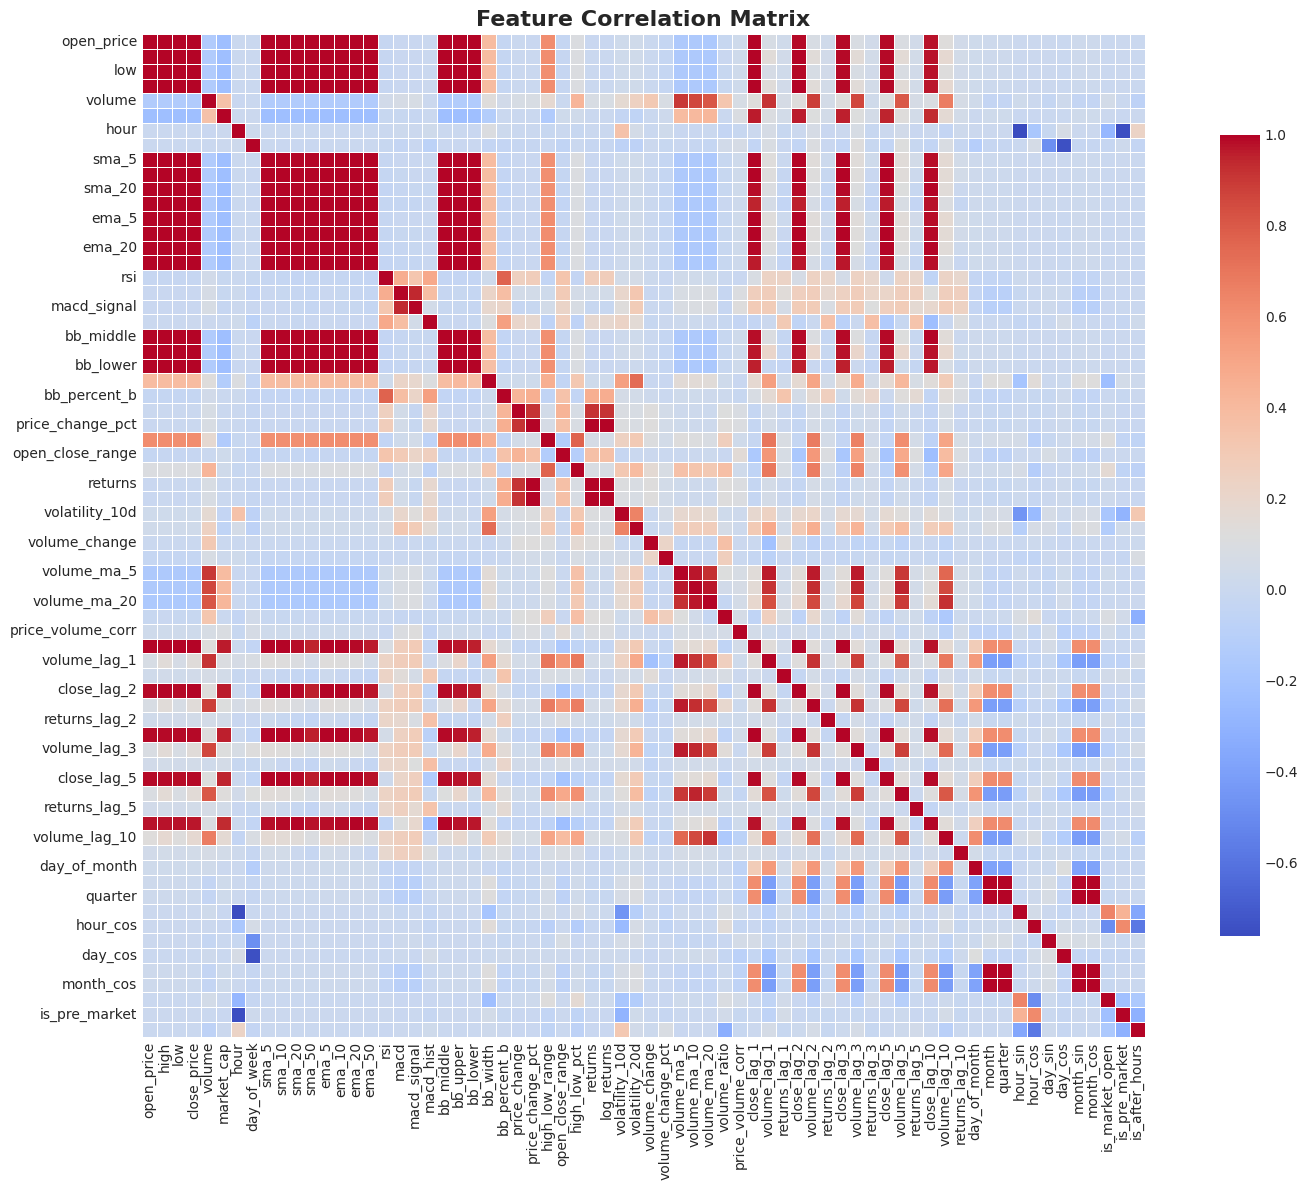

In [25]:
plt.figure(figsize=(16, 12))
sns.heatmap(
    cor_matrix,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"shrink": 0.8},
    square=True,
    linewidths=0.5,
)
plt.title("Feature Correlation Matrix", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

## Automatic Feature Selection

We'll use multiple methods to automatically identify the most important features:
1. **Variance-based filtering** - Remove low-variance features
2. **Correlation with target** - Select features highly correlated with close price
3. **Mutual Information** - Measure non-linear relationships
4. **Feature Importance from Random Forest** - Tree-based importance

In [42]:
# Prepare data for feature selection
# Select numeric features only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ["timestamp", "date_only"]
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Remove rows with NaN values (created by rolling windows and lags)
df_clean = df[feature_cols].copy()

# Replace inf/-inf with NaN
df_clean = df_clean.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
df_clean = df_clean.dropna()

print(f"Total features: {len(feature_cols)}")
print(f"Rows after removing NaN/inf: {len(df_clean):,}")
print(f"Original rows: {len(df):,}")
print(
    f"Dropped rows: {len(df) - len(df_clean):,} ({(len(df) - len(df_clean))/len(df)*100:.1f}%)"
)

Total features: 68
Rows after removing NaN/inf: 8,955
Original rows: 11,500
Dropped rows: 2,545 (22.1%)


In [43]:
# Check for problematic values in original data
inf_counts = {}
for col in feature_cols:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print("Features with infinity values:")
    for col, count in sorted(inf_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {col}: {count:,} inf values")
else:
    print("✅ No infinity values found")

Features with infinity values:
  volume_change_pct: 13 inf values
  price_volume_corr: 5 inf values


### Method 1: Variance-Based Filtering

Remove features with low variance as they provide little information.

In [33]:
from sklearn.feature_selection import VarianceThreshold

# Calculate variance for each feature
variances = df_clean.var().sort_values(ascending=False)

# Set threshold (features with variance below this are removed)
variance_threshold = 0.01
selector = VarianceThreshold(threshold=variance_threshold)
selector.fit(df_clean)

# Get features that pass the threshold
high_variance_features = df_clean.columns[selector.get_support()].tolist()

print(f"Features with variance > {variance_threshold}: {len(high_variance_features)}")
print(
    f"Removed {len(feature_cols) - len(high_variance_features)} low-variance features"
)
print(f"\nTop 15 features by variance:")
print(variances.head(15))

Features with variance > 0.01: 52
Removed 16 low-variance features

Top 15 features by variance:
market_cap           3.703219e+22
volume_lag_10        5.274869e+12
volume               5.273467e+12
volume_lag_5         5.272899e+12
volume_lag_3         5.253013e+12
volume_lag_2         5.244733e+12
volume_lag_1         5.165873e+12
volume_ma_5          4.462228e+12
volume_ma_10         3.975715e+12
volume_ma_20         3.478120e+12
volume_change        1.459094e+12
volume_change_pct    3.556286e+05
rsi                  1.220076e+03
day_of_month         6.755176e+01
hour                 3.351060e+01
dtype: float64


### Method 2: Correlation with Target Variable

Select features most correlated with the target (close_price).

Top 20 features by correlation with close_price:
low               0.999984
high              0.999982
ema_5             0.999973
open_price        0.999969
close_lag_1       0.999966
sma_5             0.999961
close_lag_2       0.999933
ema_10            0.999933
sma_10            0.999906
close_lag_3       0.999901
ema_20            0.999859
close_lag_5       0.999836
sma_20            0.999793
bb_middle         0.999793
ema_50            0.999684
close_lag_10      0.999665
bb_upper          0.999665
sma_50            0.999592
bb_lower          0.999470
high_low_range    0.581706
Name: close_price, dtype: float64


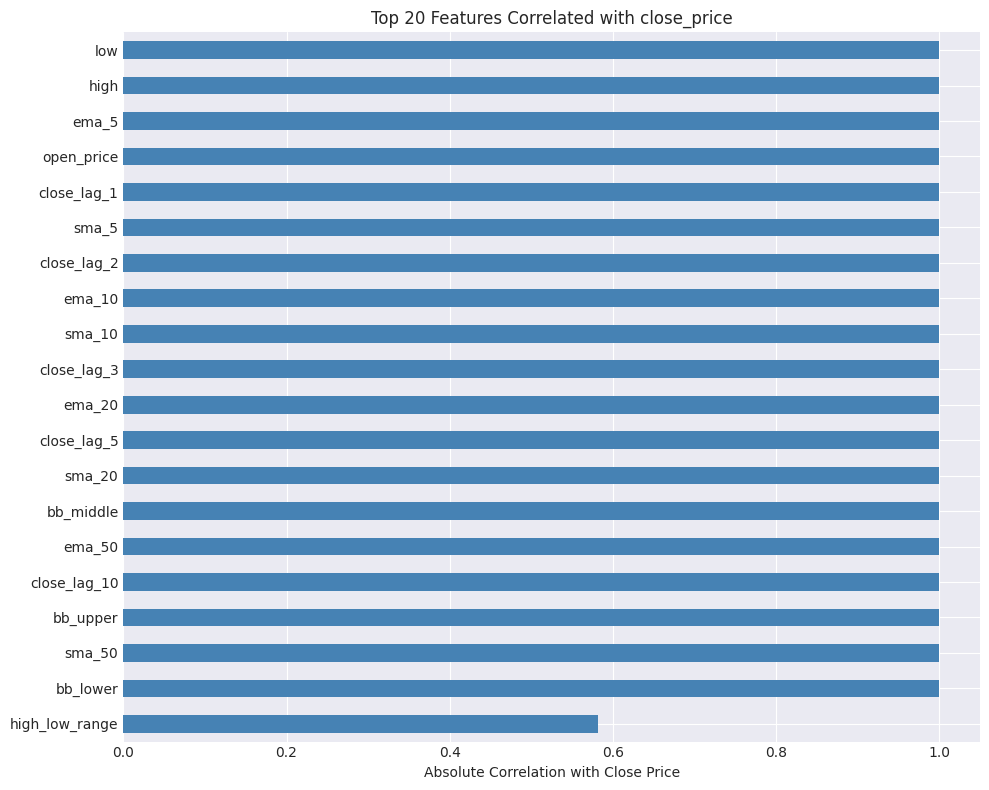

In [44]:
# Calculate correlation with target variable
target = "close_price"
correlations = df_clean.corr()[target].abs().sort_values(ascending=False)

# Remove self-correlation
correlations = correlations[correlations.index != target]

# Select top N features by correlation
top_n_corr = 20
top_corr_features = correlations.head(top_n_corr).index.tolist()

print(f"Top {top_n_corr} features by correlation with {target}:")
print(correlations.head(top_n_corr))

# Visualize
plt.figure(figsize=(10, 8))
correlations.head(20).plot(kind="barh", color="steelblue")
plt.xlabel("Absolute Correlation with Close Price")
plt.title(f"Top 20 Features Correlated with {target}")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Method 3: Mutual Information

Mutual Information captures non-linear relationships between features and target.

Top 20 features by Mutual Information:
market_cap        2.969421
high              2.967779
low               2.884433
volatility_20d    2.784338
open_price        2.728516
close_lag_1       2.716582
volume            2.670295
high_low_pct      2.654397
ema_5             2.528158
sma_5             2.447466
volume_lag_1      2.428442
close_lag_2       2.381439
bb_upper          2.219517
close_lag_3       2.207711
ema_10            2.203614
day_of_month      2.190931
volume_lag_2      2.177913
ema_50            2.159811
sma_10            2.149513
sma_50            2.111849
dtype: float64


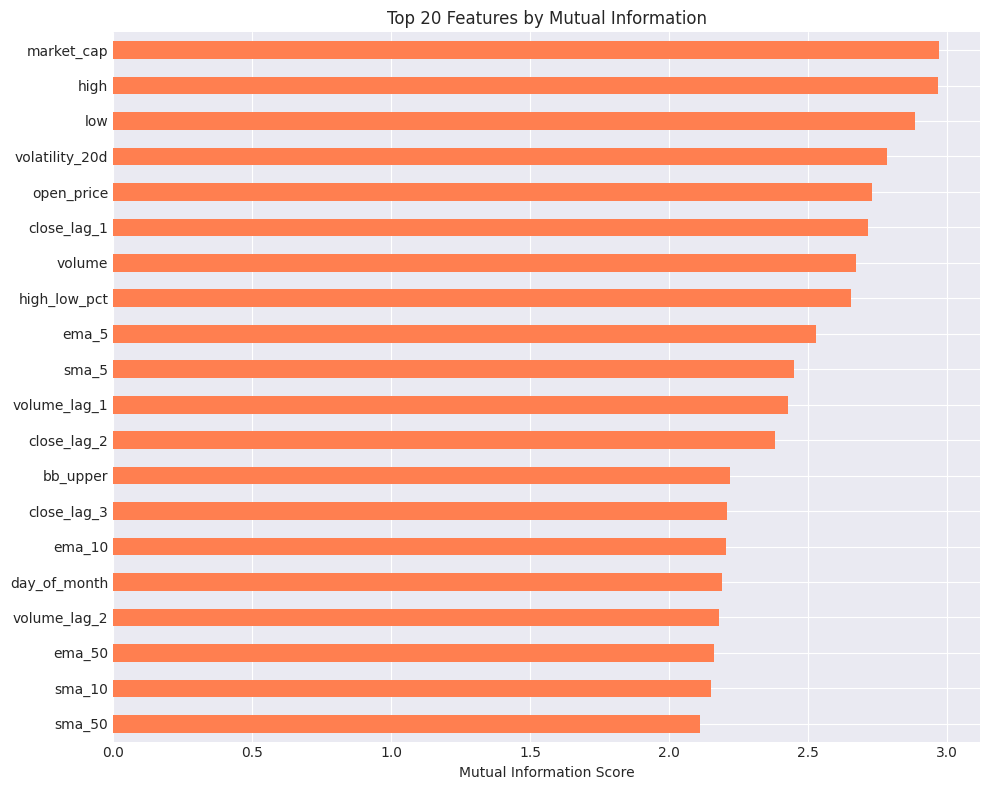

In [35]:
from sklearn.feature_selection import mutual_info_regression

# Prepare X and y
X = df_clean.drop(columns=[target])
y = df_clean[target]

# Calculate mutual information
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Select top N features by MI
top_n_mi = 20
top_mi_features = mi_scores.head(top_n_mi).index.tolist()

print(f"Top {top_n_mi} features by Mutual Information:")
print(mi_scores.head(top_n_mi))

# Visualize
plt.figure(figsize=(10, 8))
mi_scores.head(20).plot(kind="barh", color="coral")
plt.xlabel("Mutual Information Score")
plt.title("Top 20 Features by Mutual Information")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Method 4: Random Forest Feature Importance

Tree-based models can rank features by their importance in prediction.

Top 20 features by Random Forest Importance:
open_price           0.170444
ema_5                0.146876
market_cap           0.129067
low                  0.120357
high                 0.104699
close_lag_1          0.100955
sma_5                0.092255
bb_upper             0.090924
ema_10               0.018801
close_lag_2          0.009280
close_lag_3          0.009130
open_close_range     0.001360
bb_middle            0.000806
ema_20               0.000602
sma_50               0.000561
sma_10               0.000515
sma_20               0.000333
price_volume_corr    0.000324
ema_50               0.000290
high_low_range       0.000244
dtype: float64


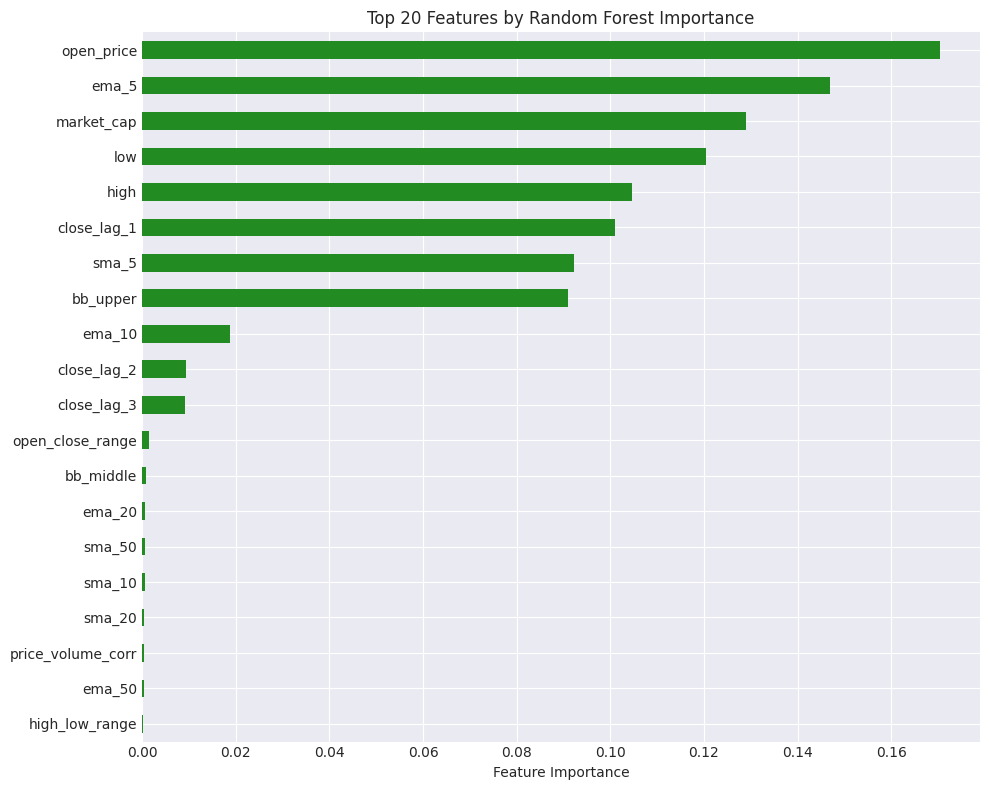

In [36]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
)
rf_model.fit(X, y)

# Get feature importances
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(
    ascending=False
)

# Select top N features by importance
top_n_rf = 20
top_rf_features = rf_importances.head(top_n_rf).index.tolist()

print(f"Top {top_n_rf} features by Random Forest Importance:")
print(rf_importances.head(top_n_rf))

# Visualize
plt.figure(figsize=(10, 8))
rf_importances.head(20).plot(kind="barh", color="forestgreen")
plt.xlabel("Feature Importance")
plt.title("Top 20 Features by Random Forest Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Combined Feature Selection

Combine results from all methods to get a consensus ranking.

In [45]:
# Create a scoring system: features get points based on their rank in each method
def rank_features(feature_list, all_features):
    """Give each feature a score based on its position (higher rank = higher score)"""
    scores = {}
    max_score = len(feature_list)
    for i, feature in enumerate(feature_list):
        scores[feature] = max_score - i
    return scores


# Score features from each method
corr_scores = rank_features(top_corr_features, feature_cols)
mi_scores_ranked = rank_features(top_mi_features, feature_cols)
rf_scores = rank_features(top_rf_features, feature_cols)

# Combine scores
combined_scores = {}
for feature in feature_cols:
    combined_scores[feature] = (
        corr_scores.get(feature, 0)
        + mi_scores_ranked.get(feature, 0)
        + rf_scores.get(feature, 0)
    )

# Sort by combined score
combined_scores = pd.Series(combined_scores).sort_values(ascending=False)

# Select top N features
top_n_combined = 15
top_features_auto = combined_scores.head(top_n_combined).index.tolist()

print(f"Top {top_n_combined} features by combined ranking:")
print(combined_scores.head(top_n_combined))
print(f"\n✅ Automatically selected features:")
print(top_features_auto)

Top 15 features by combined ranking:
low               55
high              54
open_price        53
ema_5             49
close_lag_1       46
sma_5             40
market_cap        38
close_lag_2       34
ema_10            31
close_lag_3       28
bb_upper          25
sma_10            19
ema_20            17
volatility_20d    17
bb_middle         15
dtype: int64

✅ Automatically selected features:
['low', 'high', 'open_price', 'ema_5', 'close_lag_1', 'sma_5', 'market_cap', 'close_lag_2', 'ema_10', 'close_lag_3', 'bb_upper', 'sma_10', 'ema_20', 'volatility_20d', 'bb_middle']


### Visualize Automatically Selected Features

Correlation heatmap of top features selected automatically.

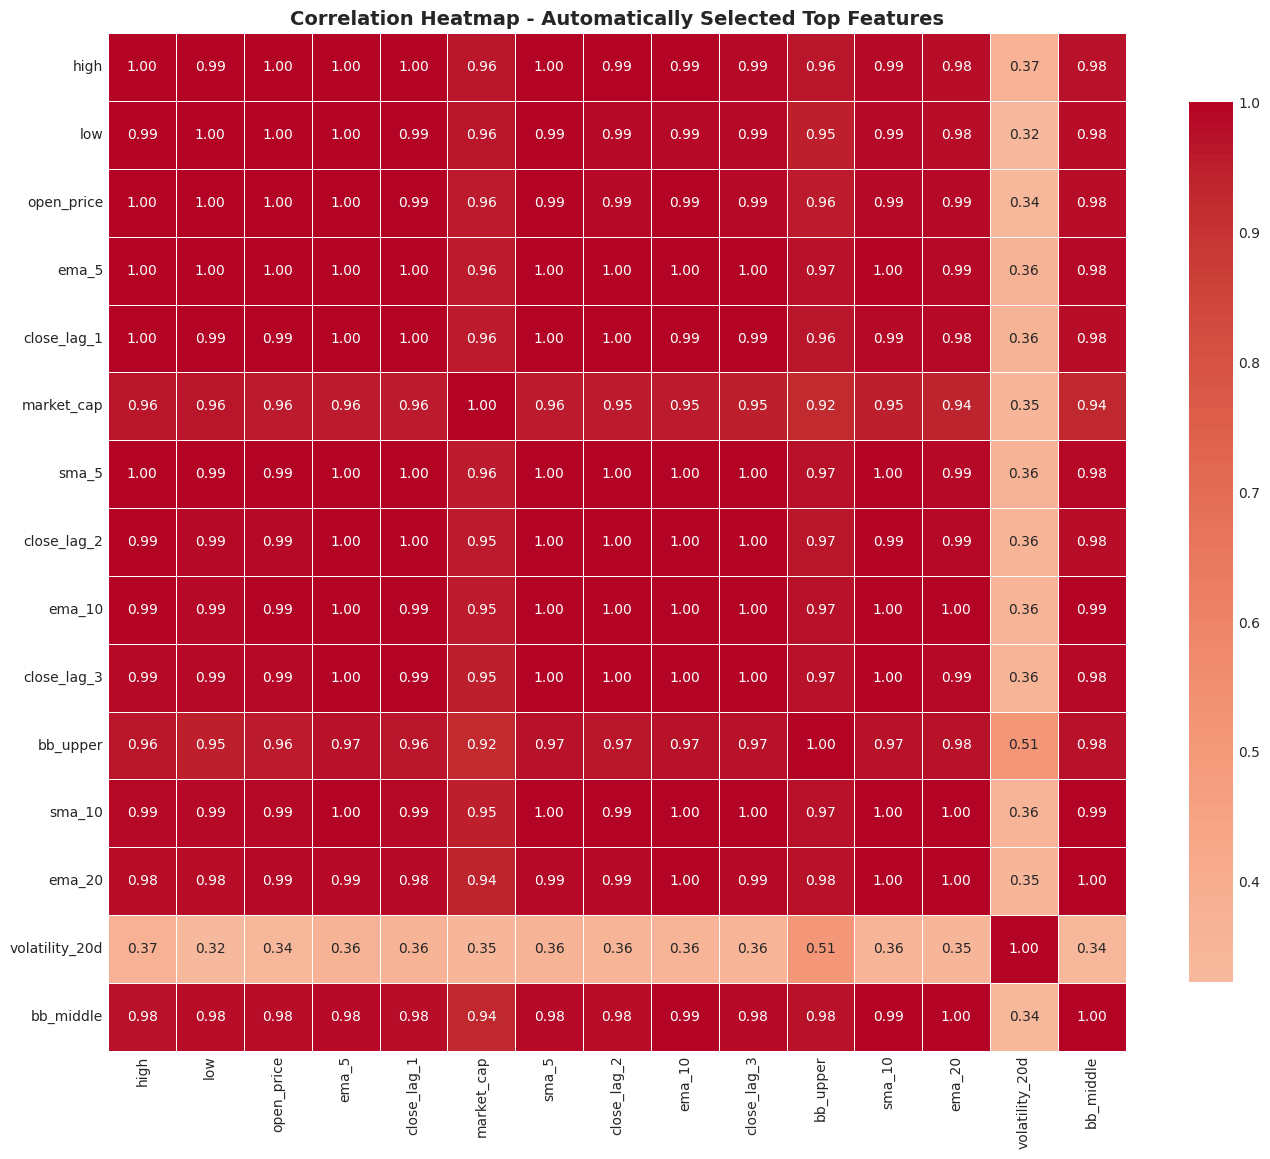

In [38]:
# Calculate correlation matrix for selected features
selected_corr_matrix = df_clean[top_features_auto].corr()

# Visualize
plt.figure(figsize=(14, 12))
sns.heatmap(
    selected_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title(
    "Correlation Heatmap - Automatically Selected Top Features",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

### Remove Multicollinear Features

Remove highly correlated features to reduce redundancy.

In [46]:
def remove_multicollinear_features(df, features, threshold=0.95):
    """
    Remove highly correlated features to reduce multicollinearity.

    Parameters:
    df (pd.DataFrame): DataFrame containing the features
    features (list): List of feature names to check
    threshold (float): Correlation threshold above which features are removed

    Returns:
    list: List of features after removing multicollinear ones
    """
    corr_matrix = df[features].corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Keep features not in to_drop list
    features_cleaned = [f for f in features if f not in to_drop]

    return features_cleaned, to_drop


# Apply multicollinearity removal with adjusted threshold
# Note: For stock price features, some correlation is expected
# Using 0.98 instead of 0.95 to be less aggressive
final_features, dropped_features = remove_multicollinear_features(
    df_clean, top_features_auto, threshold=0.98
)

print(f"Original features: {len(top_features_auto)}")
print(f"Dropped due to multicollinearity (>0.98): {len(dropped_features)}")
if dropped_features:
    print(f"Dropped features: {dropped_features}")
print(f"\n✅ Final selected features ({len(final_features)}):")
for i, feat in enumerate(final_features, 1):
    print(f"  {i}. {feat}")

Original features: 15
Dropped due to multicollinearity (>0.98): 12
Dropped features: ['high', 'open_price', 'ema_5', 'close_lag_1', 'sma_5', 'close_lag_2', 'ema_10', 'close_lag_3', 'bb_upper', 'sma_10', 'ema_20', 'bb_middle']

✅ Final selected features (3):
  1. low
  2. market_cap
  3. volatility_20d


### Alternative: Feature Diversity Strategy

Since stock price features are naturally highly correlated, let's use a strategy that ensures feature diversity by selecting representative features from different categories.

In [47]:
# Define feature categories
feature_categories = {
    "price_basic": ["open_price", "high", "low", "close_price"],
    "price_lag": [f"close_lag_{i}" for i in [1, 2, 3, 5, 10]],
    "sma": [f"sma_{i}" for i in [5, 10, 20, 50]],
    "ema": [f"ema_{i}" for i in [5, 10, 20, 50]],
    "bollinger": ["bb_upper", "bb_middle", "bb_lower", "bb_width", "bb_percent_b"],
    "momentum": ["rsi", "macd", "macd_signal", "macd_hist"],
    "volatility": [
        "volatility_10d",
        "volatility_20d",
        "high_low_range",
        "high_low_pct",
    ],
    "returns": ["returns", "log_returns", "price_change", "price_change_pct"],
    "volume": ["volume", "volume_ratio", "volume_ma_5", "volume_ma_10", "volume_ma_20"],
    "volume_lag": [f"volume_lag_{i}" for i in [1, 2, 3, 5, 10]],
    "market": ["market_cap"],
    "time": [
        "hour",
        "day_of_week",
        "day_of_month",
        "month",
        "quarter",
        "hour_sin",
        "hour_cos",
        "day_sin",
        "day_cos",
        "month_sin",
        "month_cos",
    ],
}

# Select best feature from each category based on combined scores
diverse_features = []
for category, features in feature_categories.items():
    # Find features in this category that are in our feature_cols
    available = [f for f in features if f in feature_cols and f != "close_price"]
    if available:
        # Get the one with highest combined score
        category_scores = combined_scores[available]
        if not category_scores.empty:
            best_feature = category_scores.idxmax()
            diverse_features.append(best_feature)
            print(
                f"{category:15s}: {best_feature:20s} (score: {combined_scores[best_feature]})"
            )

print(f"\n✅ Diverse feature set ({len(diverse_features)} features):")
print(diverse_features)

price_basic    : low                  (score: 55)
price_lag      : close_lag_1          (score: 46)
sma            : sma_5                (score: 40)
ema            : ema_5                (score: 49)
bollinger      : bb_upper             (score: 25)
momentum       : rsi                  (score: 0)
volatility     : volatility_20d       (score: 17)
returns        : returns              (score: 0)
volume         : volume               (score: 14)
volume_lag     : volume_lag_1         (score: 10)
market         : market_cap           (score: 38)
time           : day_of_month         (score: 5)

✅ Diverse feature set (12 features):
['low', 'close_lag_1', 'sma_5', 'ema_5', 'bb_upper', 'rsi', 'volatility_20d', 'returns', 'volume', 'volume_lag_1', 'market_cap', 'day_of_month']


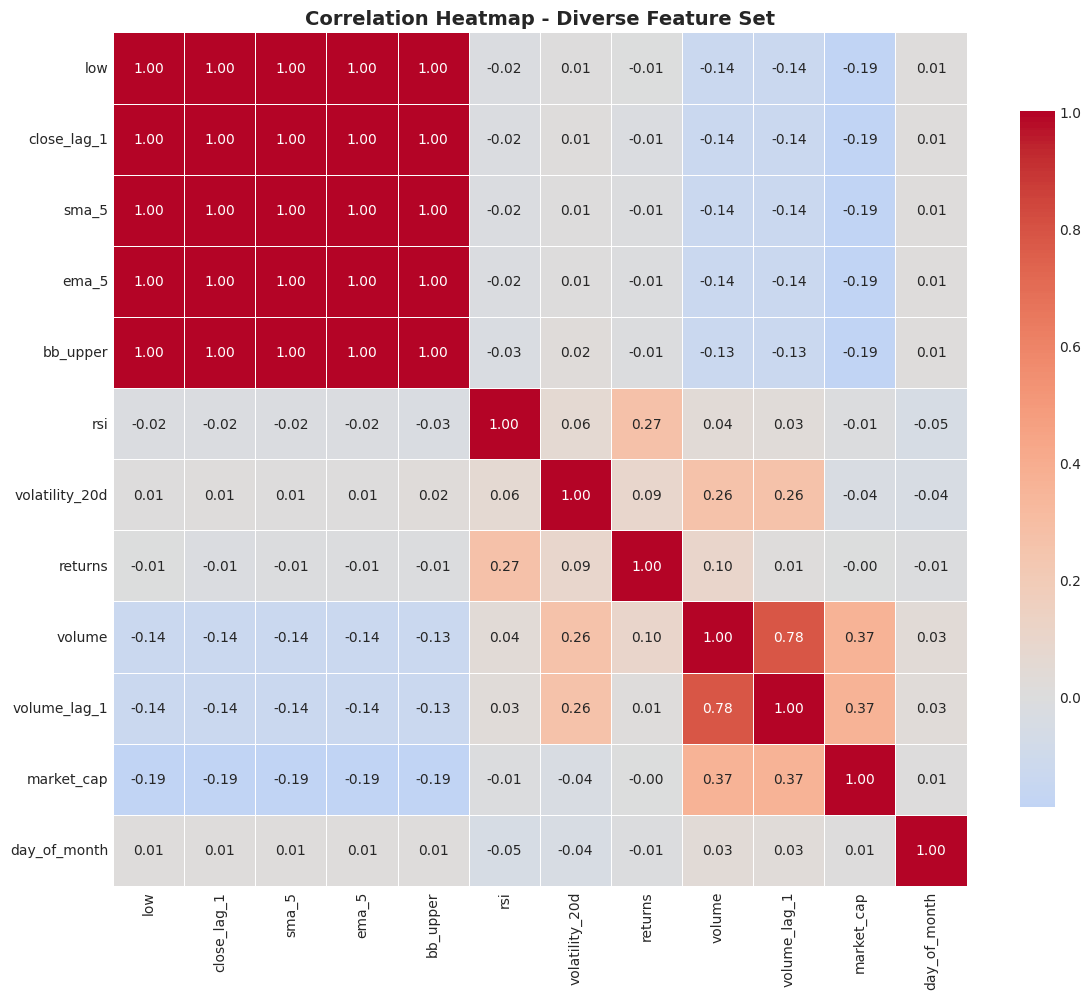


✅ Using diverse feature set as final features: 12 features


In [48]:
# Visualize correlation of diverse features
diverse_corr_matrix = df_clean[diverse_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    diverse_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Heatmap - Diverse Feature Set", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Update final_features to use diverse set
final_features = diverse_features
print(
    f"\n✅ Using diverse feature set as final features: {len(final_features)} features"
)

In [49]:
import json

# Save processed data with all features
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Save full feature set (all engineered features)
df_with_features = df.copy()
output_file = output_dir / "features_engineered.parquet"
df_with_features.to_parquet(output_file, index=False, compression="snappy")
print(f"✅ Saved full feature set to: {output_file}")
print(f"   Shape: {df_with_features.shape}")
print(f"   Total features: {len(df_with_features.columns)}")

# 2. Save selected features WITH metadata columns
# CRITICAL: Include symbol and timestamp for time-series modeling
metadata_cols = ["symbol", "timestamp"]
feature_cols_with_target = final_features + ["close_price"]

# Align with cleaned data indices
df_selected = df.loc[df_clean.index, metadata_cols + feature_cols_with_target].copy()

output_file_selected = output_dir / "features_selected.parquet"
df_selected.to_parquet(output_file_selected, index=False, compression="snappy")
print(f"\n✅ Saved selected features to: {output_file_selected}")
print(f"   Shape: {df_selected.shape}")
print(f"   Columns: {df_selected.columns.tolist()}")

# 3. Save feature metadata for reproducibility
feature_metadata = {
    "creation_date": pd.Timestamp.now().isoformat(),
    "selected_features": final_features,
    "target": "close_price",
    "metadata_columns": metadata_cols,
    "num_records": len(df_selected),
    "num_stocks": len(df_selected["symbol"].unique()),
    "date_range": {
        "start": str(df_selected["timestamp"].min()),
        "end": str(df_selected["timestamp"].max()),
    },
    "symbols": sorted(df_selected["symbol"].unique().tolist()),
    "feature_selection_method": "diversity_strategy",
    "data_quality": {
        "original_rows": len(df),
        "cleaned_rows": len(df_selected),
        "retention_rate": f"{len(df_selected)/len(df)*100:.2f}%",
    },
}

metadata_file = output_dir / "feature_metadata.json"
with open(metadata_file, "w") as f:
    json.dump(feature_metadata, f, indent=2)
print(f"\n✅ Saved feature metadata to: {metadata_file}")

# 4. Display comprehensive summary
print("\n" + "=" * 70)
print("📊 FEATURE ENGINEERING COMPLETE")
print("=" * 70)
print(f"Original dataset:     {len(df):,} rows × {len(df.columns)} columns")
print(
    f"After cleaning:       {len(df_selected):,} rows ({len(df_selected)/len(df)*100:.1f}% retained)"
)
print(f"Total features:       {len(df_with_features.columns)}")
print(f"Selected features:    {len(final_features)}")
print(f"Stocks:               {len(df_selected['symbol'].unique())}")
print(
    f"Date range:           {df_selected['timestamp'].min().date()} to {df_selected['timestamp'].max().date()}"
)
print(f"\n📁 Files saved in: {output_dir}")
print(f"  1. {output_file.name:<35} ({df_with_features.shape[0]:>6,} rows)")
print(f"  2. {output_file_selected.name:<35} ({df_selected.shape[0]:>6,} rows)")
print(f"  3. {metadata_file.name:<35}")
print("=" * 70)
print("\n✅ Ready for model training!")
print(f"   Load with: pd.read_parquet('{output_file_selected}')")

✅ Saved full feature set to: ../data/processed/features_engineered.parquet
   Shape: (11500, 73)
   Total features: 73

✅ Saved selected features to: ../data/processed/features_selected.parquet
   Shape: (8955, 15)
   Columns: ['symbol', 'timestamp', 'low', 'close_lag_1', 'sma_5', 'ema_5', 'bb_upper', 'rsi', 'volatility_20d', 'returns', 'volume', 'volume_lag_1', 'market_cap', 'day_of_month', 'close_price']

✅ Saved feature metadata to: ../data/processed/feature_metadata.json

📊 FEATURE ENGINEERING COMPLETE
Original dataset:     11,500 rows × 73 columns
After cleaning:       8,955 rows (77.9% retained)
Total features:       73
Selected features:    12
Stocks:               15
Date range:           2025-09-03 to 2025-10-15

📁 Files saved in: ../data/processed
  1. features_engineered.parquet         (11,500 rows)
  2. features_selected.parquet           ( 8,955 rows)
  3. feature_metadata.json              

✅ Ready for model training!
   Load with: pd.read_parquet('../data/processed/fea